# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

План работы:

1) проведем предобработку данных;

2) добавим необходимые для исследования столбцы с данными;

3) изучим все доступные параматры проданных квартир (площади, этажность, цены, скорость продажи, расстояния до объектов, даты публикаций;

4) оценим влияние этих факторов на цену объекта;

5) рассчитаем среднюю стоимость квадратного метра для самых популярных населенных пунктов и выясним, как удаление от центра в среднем влияет на стоимость.


## Откройте файл с данными и изучите общую информацию. 

In [1]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

In [3]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

In [4]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

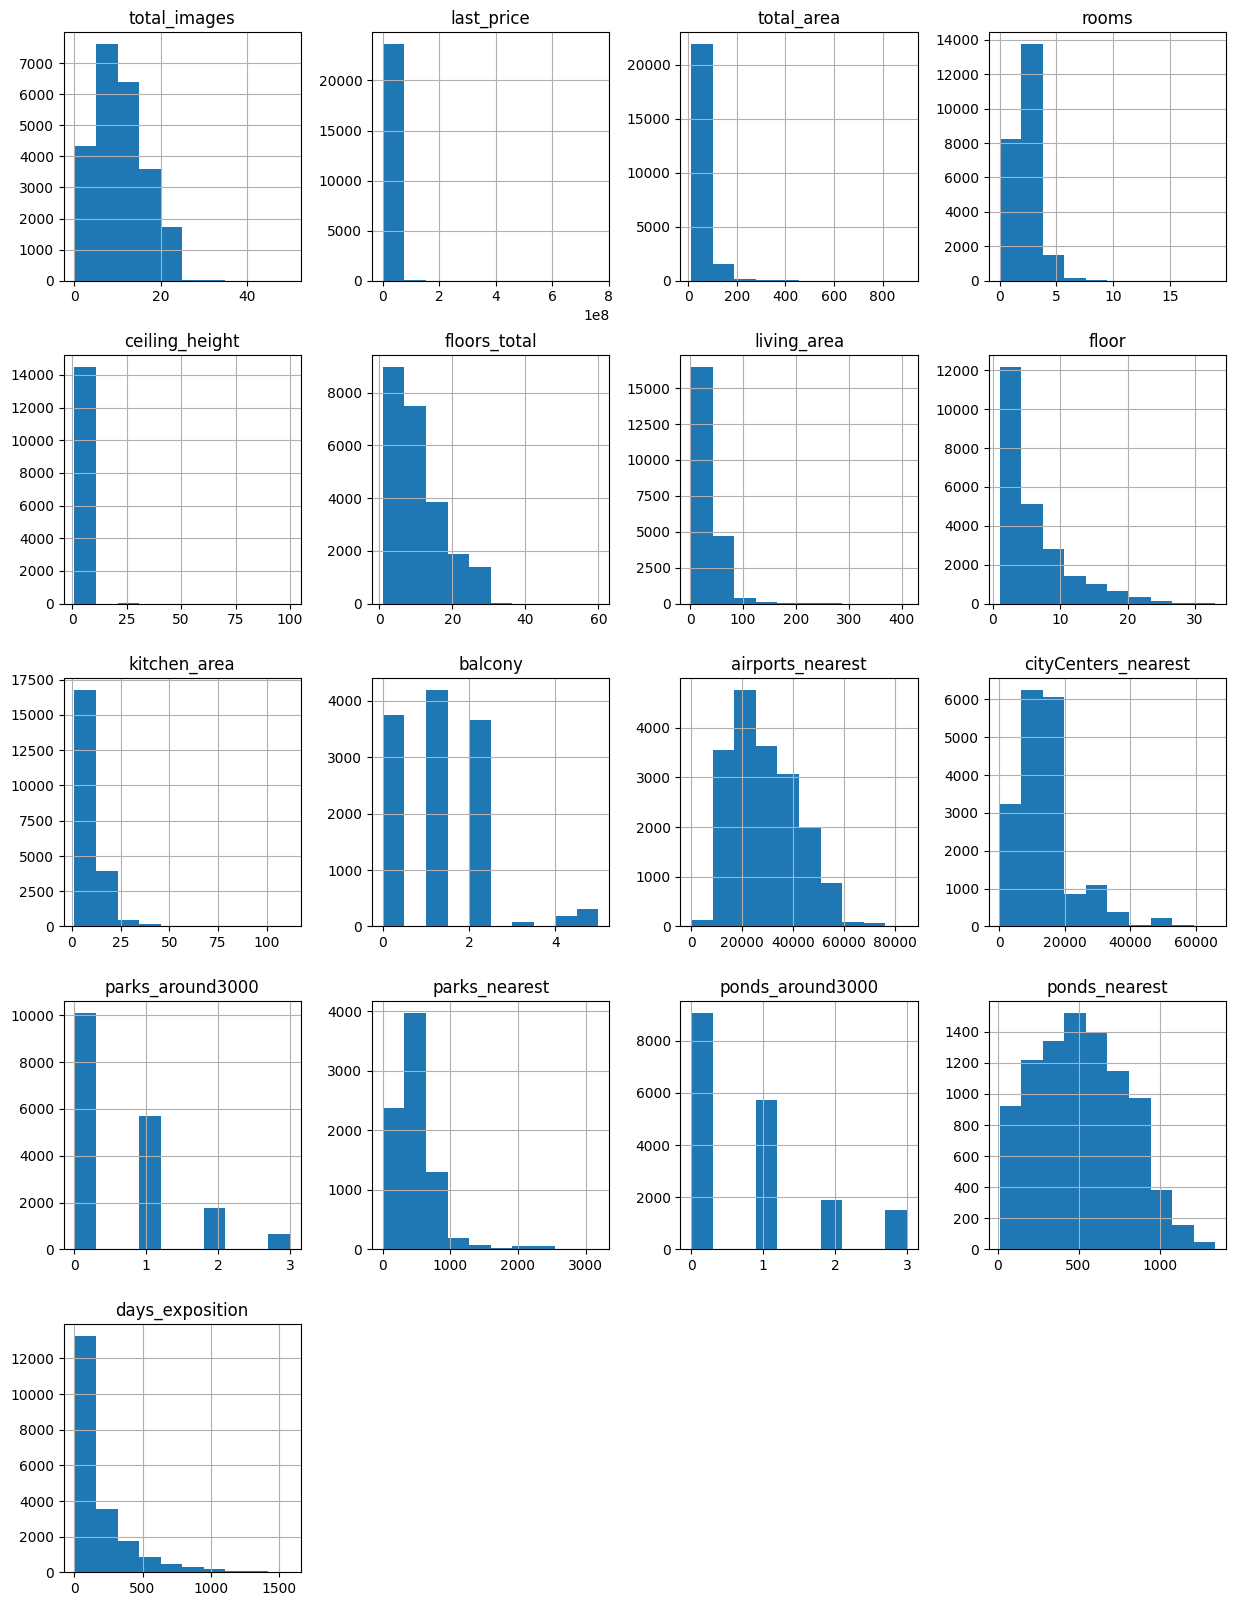

In [6]:
data.hist(figsize=(15,20))
plt.show()

**Вывод:**
<div style="border: solid pink 2px; padding: 20px">
Таблица состоит из 23699 записей, в части столбцов присутсвуют пропуски, так же стоит изменить тип некоторые типы данных.

## Предобработка данных

Посмотрим на картину с пропусками в целом

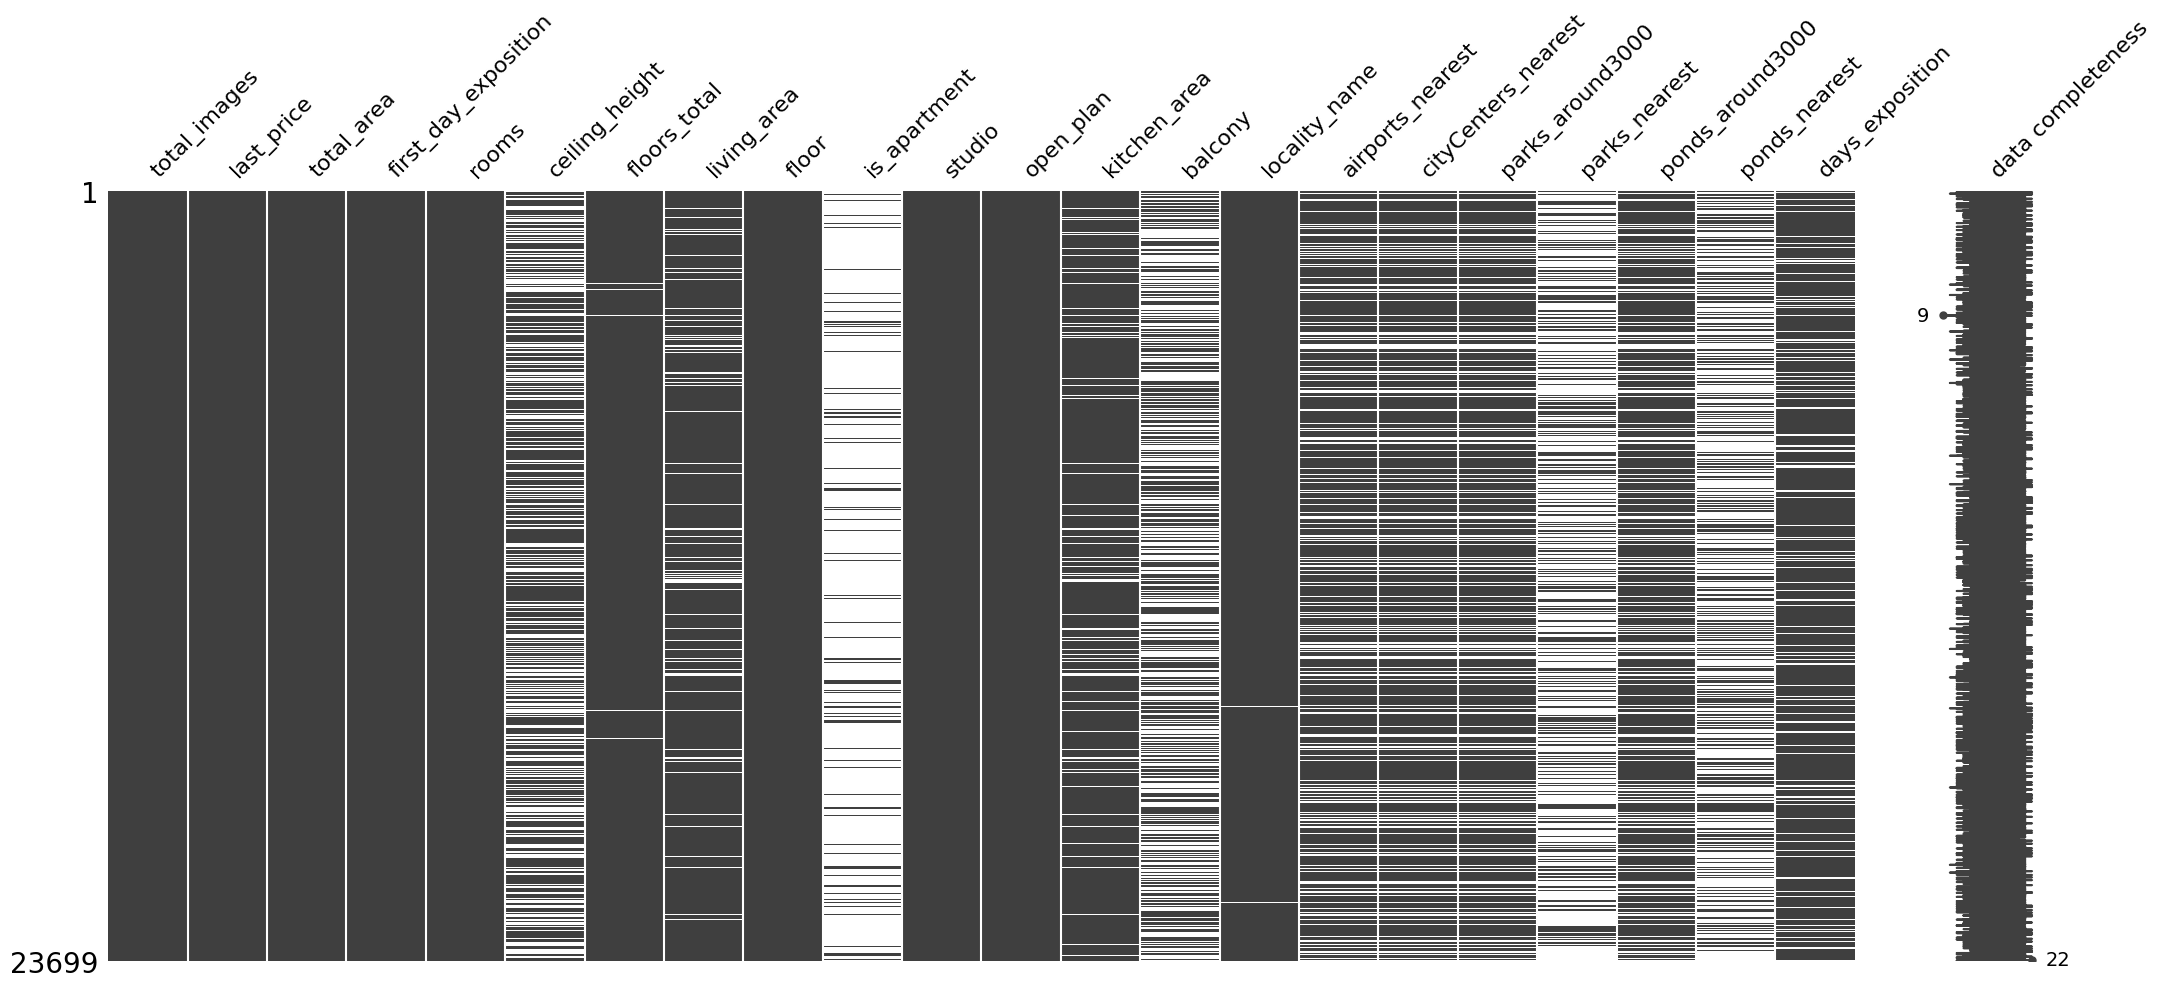

In [7]:
msno.matrix(data, labels=True);

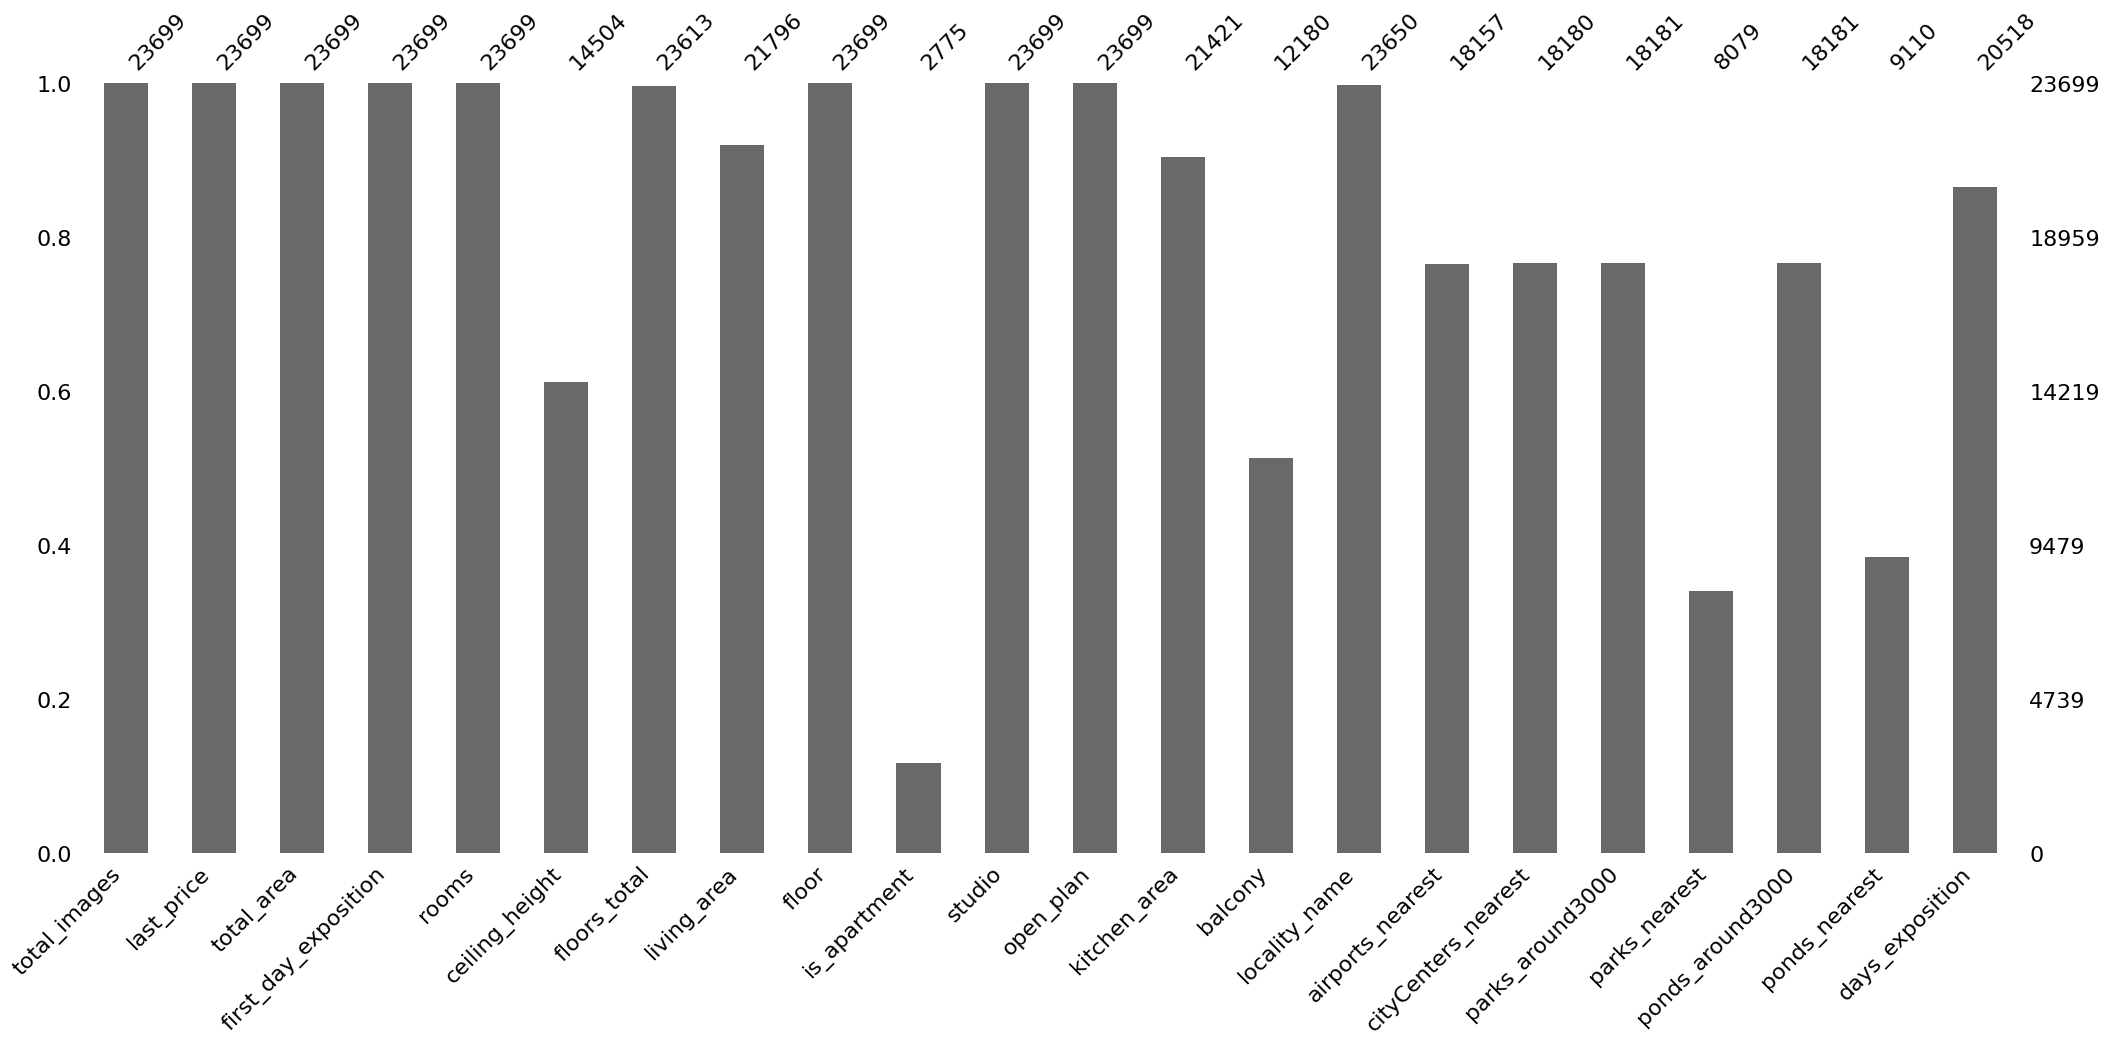

In [8]:
msno.bar(data);

###  Заполним пропуски:

Присутствуют пропуски в столбцах: 
- ceiling_height
- floors_total
- living_area
- is_apartment 
- kitchen_area
- balcony
- locality_name
- airports_nearest
- cityCenters_nearest
- parks_around3000
- parks_nearest
- ponds_around3000
- ponds_nearest
- days_exposition 

Скорее всего пропуски в столбце is_apartment обусловлены тем, что если продавец выставляет именно квартиру, то он просто не указывает, является это не является апартаментами, поэтому можно заполнить пропуски значениями False. 

In [9]:
data['is_apartment'].isna().sum() 

20924

In [10]:
data['is_apartment'] = data['is_apartment'].fillna(False) 

In [11]:
data['is_apartment'].isna().sum() # проверим заполнение

0

Пропуски в количестве балконов стоблце balcony скорее всего связаны с тем, что продавец не указал их, так как в квартире их нет, поэтому мы заменим их на ноль.

In [12]:
data['balcony'].isna().sum() 

11519

In [13]:
data['balcony'] = data['balcony'].fillna(0) 

In [14]:
data['balcony'].isna().sum() # проверим заполнение

0

Проверим пропуски в этажности домов, и, если их не много, удалим

In [15]:
data['floors_total'].isna().sum()

86

In [16]:
data = data[data['floors_total'].notna()]

In [17]:
data['floors_total'].isna().sum() # проверим заполнение

0

Вероятно продавцы просто не указывают высоту потолков, и так как это квартиры, то можно заменить эти пропуски медианным значением высоты потолков (чтобы не учитывать влияние выбросов).

In [18]:
data['ceiling_height'].isna().sum() 

9118

In [19]:
data['ceiling_height'].describe() # статистики для столбца с высотой потолков

count    14495.000000
mean         2.771495
std          1.261445
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [20]:
data.loc[((data['locality_name']=='Санкт-Петербург') & (data['cityCenters_nearest']<=5000))] 
# выделим исторический центр Санкт-Петербурга 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
24,8,6500000.0,97.20,2015-10-31T00:00:00,2,NaN,3.0,46.5,1,False,...,19.60,0.0,Санкт-Петербург,20052.0,2336.0,3.0,411.0,3.0,124.0,265.0
35,6,15500000.0,149.00,2017-06-26T00:00:00,5,NaN,5.0,104.0,4,False,...,17.00,0.0,Санкт-Петербург,23670.0,3502.0,0.0,NaN,1.0,779.0,644.0
61,18,7990000.0,74.00,2017-08-24T00:00:00,2,NaN,4.0,43.0,4,False,...,20.00,0.0,Санкт-Петербург,22568.0,4288.0,1.0,363.0,0.0,NaN,609.0
63,2,20000000.0,118.00,2018-09-11T00:00:00,3,3.00,9.0,68.0,7,False,...,16.00,0.0,Санкт-Петербург,26055.0,4800.0,1.0,648.0,1.0,779.0,37.0
99,32,9600000.0,90.00,2017-09-26T00:00:00,4,NaN,5.0,67.0,2,False,...,8.00,0.0,Санкт-Петербург,23277.0,2818.0,0.0,NaN,0.0,NaN,104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23644,7,4990000.0,62.50,2018-04-26T00:00:00,2,2.70,4.0,32.3,4,False,...,12.10,0.0,Санкт-Петербург,20141.0,4415.0,1.0,560.0,1.0,171.0,166.0
23648,14,10100000.0,78.00,2017-05-12T00:00:00,3,3.27,5.0,48.6,5,False,...,8.20,0.0,Санкт-Петербург,20933.0,1113.0,1.0,621.0,2.0,117.0,621.0
23665,11,4250000.0,47.00,2016-05-20T00:00:00,1,NaN,6.0,18.2,1,False,...,14.60,0.0,Санкт-Петербург,20503.0,4946.0,2.0,624.0,1.0,519.0,131.0
23691,11,9470000.0,72.90,2016-10-13T00:00:00,2,2.75,25.0,40.3,7,False,...,10.60,1.0,Санкт-Петербург,19424.0,4489.0,0.0,NaN,1.0,806.0,519.0


In [21]:
data.loc[((data['locality_name']=='Санкт-Петербург') & (data['cityCenters_nearest']<=5000))]['ceiling_height'].notna().sum()
# найдем среди этих записей не пустые значение в столбце с высотой потолков

1384

In [22]:
# check
data.loc[(data['locality_name']=='Санкт-Петербург') & (data['cityCenters_nearest']<=5000) &\
     (data['ceiling_height'].notna()), 'ceiling_height'].median()

3.1

In [23]:
data['ceiling_height'] = data['ceiling_height'].fillna(2.65)


In [24]:
data['ceiling_height'].describe() 

count    23613.000000
mean         2.724581
std          0.990085
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

Среднее изменилось незначительно, стандартное отклонение уменьшилось, а медиана осталась без изменений (что ожидаемо, ведь пропуски заполнены именно ей).

In [25]:
data[data['total_area'] <= data['living_area']+data['kitchen_area']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
184,7,2600000.0,30.20,2018-02-14T00:00:00,1,2.65,9.0,26.10,5,False,...,6.20,0.0,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
220,8,3890000.0,37.00,2018-07-09T00:00:00,1,2.50,25.0,28.00,6,False,...,9.00,0.0,Санкт-Петербург,25408.0,16166.0,0.0,NaN,0.0,NaN,28.0
545,9,4700000.0,23.80,2018-12-28T00:00:00,1,2.65,18.0,20.00,9,False,...,5.00,0.0,Санкт-Петербург,9731.0,11849.0,0.0,NaN,0.0,NaN,108.0
551,8,3100000.0,31.59,2018-03-08T00:00:00,1,2.70,19.0,30.55,2,False,...,9.28,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,70.0
601,12,5600000.0,53.70,2017-04-18T00:00:00,2,2.50,12.0,48.30,5,False,...,7.00,2.0,Санкт-Петербург,50477.0,13252.0,2.0,220.0,1.0,1250.0,167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22869,0,15000000.0,25.00,2018-07-25T00:00:00,1,100.00,5.0,14.00,5,True,...,11.00,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0
22963,16,3150000.0,102.00,2018-06-26T00:00:00,5,2.65,9.0,78.00,8,False,...,24.00,1.0,Кингисепп,NaN,NaN,NaN,NaN,NaN,NaN,57.0
23202,13,4919880.0,67.92,2018-10-23T00:00:00,2,2.65,3.0,63.00,3,False,...,13.04,0.0,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,60.0
23297,10,1850000.0,48.20,2019-03-13T00:00:00,2,2.65,5.0,42.20,2,False,...,6.00,1.0,Высоцк,NaN,NaN,NaN,NaN,NaN,NaN,45.0


Пропуски в столбце kitchen_area с площадью кухни и пропуски в столбце с жилой площадью living_area логично заполнить нечем.

In [26]:
data['locality_name'].isna().sum() # пропуски в названиях населенных пунктов

48

Заполнить логично эти пропуски не удастся, оставим как есть

- Пропуски в airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest связаны между собой, так как если, по какой-то причине, автоматически не удалось выяснить, где на карте находится объект, то и все эти расстояния определить тоже не получится. Либо же эти часть из них (airports_nearest, cityCenters_nearest, parks_around3000,ponds_around3000) определена, а пропуски в расстояниях до ближайшего парка/водоёма(parks_nearest, ponds_nearest) получились из-за отсутсвия их в радиусе 3 км.
- Так как у нас нет никаких идентификационных данных о каждом объявлении, выяснить, где конкретно находилась каждая квартира с пропусками мы не можем, логично заполнить расстояния мы тоже не можем. 

Проверим пропуски в столбце с количеством дней публикации объявления

In [27]:
data['days_exposition'].isna().sum() 

3172

In [28]:
data['days_exposition'].describe()

count    20441.000000
mean       180.884839
std        219.685543
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

- Разница в медианном значении (95 дней) и среднем (180 дней) существенная, есть что-то, что сильно сдвигает среднее в большую сторону. Заполнять пропуски средним или медианным значениями не будем. 
- Причина пропусков в этом столбце скорее всего связана с автоматической работой сервера, об этом стоит сообщить.

**Вывод:**
<div style="border: solid pink 2px; padding: 20px">
В таблице много пропусков, на это стоит обратить внимание. Возможно стоит при заполнении объявления некоторые поля обязательными для ввода, например жилую площадь, населенный пункт. Так же стоит выяснить откуда пропуски в автоматически заполняемых столбцах, например в днях размещения.
    

### Изменим тип данных где необходимо

В столбце first_day_exposition, указывающем дату публикации объявления, тип данных object заменим на datetime64. 

In [29]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
# переведим значения в столбце first_day_exposition в datetime

В столбце days_exposition округлим до целых

In [30]:
def to_round(value): # функция, которая отбросит дробную часть для упрощения поиска по конкретным целым числам (дням)
    try:
        return int(value)
    except:
        pass

In [31]:
data['days_exposition'] = data['days_exposition'].apply(to_round) 

Поменяем типа данных столбцов floors_total и balcony на int.

In [32]:
data['floors_total'] = data['floors_total'].astype('int')

In [33]:
data['balcony'] = data['balcony'].astype('int')

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        23613 non-null  float64       
 6   floors_total          23613 non-null  int32         
 7   living_area           21743 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          23613 non-null  bool          
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21382 non-null  float64       
 13  balcony         

**Вывод:**
<div style="border: solid pink 2px; padding: 20px">
Тип данных нужно изменить для корректности работы с данными даты, например для получения информации по годам, месяцам или дням. Так же округление поможет в точном поиске по количеству дней. Изменять тип данных на нужный важно для корректной работы с данными таблицы.
    

### Изучим и устраним дубликаты

Неявные дубликаты могут скрываться в названиях населенных пунктов, посмотрим уникальные значения в этом столбце

In [35]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Cоздадим список из видов населенных пунктов чтобы удалить их из строк столбца locality_name, таким образом избавляясь от дубликатов.

In [36]:
list_name = ['посёлок городского типа', 'поселок городского типа', 'садовое товарищество', 'городской поселок',\
             'городской посёлок', 'садоводческое некоммерческое товарищество',\
             'поселок при железнодорожной станции', 'посёлок при железнодорожной станции', \
             'поселок станции', 'посёлок станции', 'коттеджный посёлок', 'коттеджный поселок',\
             'поселок', 'посёлок', 'деревня', 'село']

Перебирая виды населенных пунктов из списка, при их нахождении, удаляем их, и перезаписываем в столбец locality_name

In [37]:
for delete_location in list_name:
    data['locality_name'] = data['locality_name'].str.replace(f'{delete_location} ', '')

In [38]:
data['locality_name'].unique() # проверяем, все ли удалилось 

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

In [39]:
data.duplicated().sum() # проверим, нет ли повторяющихся полностью строк

0

**Вывод:**
<div style="border: solid pink 2px; padding: 20px">
Для дальнейшего избегания таких неявных дубликатов в названиях населенных пунктов стоит сделать поле, которое при вводе названия будет предлагать вариант населенного пункта и его названия.

In [40]:
# check
data.locality_name.nunique()

305

In [41]:
data[data.duplicated(subset=['total_area', 'floor', 'rooms', 'locality_name', 'cityCenters_nearest', 'last_price'], keep='first')]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2395,9,1750000.0,44.0,2016-06-09,1,2.65,5,18.0,1,False,...,14.0,0,Кириши,NaN,NaN,NaN,NaN,NaN,NaN,22.0
7458,7,2350000.0,32.0,2015-02-17,1,2.65,5,16.0,3,False,...,5.0,0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,751.0
8289,20,2150000.0,31.4,2017-08-22,1,2.50,4,18.7,2,False,...,5.0,0,Кузьмоловский,NaN,NaN,NaN,NaN,NaN,NaN,78.0
8705,8,3450000.0,40.0,2016-07-04,1,2.65,12,NaN,4,False,...,NaN,0,Санкт-Петербург,31552.0,12062.0,0.0,NaN,0.0,NaN,608.0
9886,1,2533531.0,42.5,2016-11-25,1,2.56,18,19.8,7,False,...,NaN,0,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,549.0
13076,9,1200000.0,30.0,2017-12-15,1,2.60,4,24.0,4,False,...,6.0,0,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,188.0
13627,11,26000000.0,130.0,2016-06-30,3,3.18,6,69.2,1,False,...,30.0,0,Санкт-Петербург,25201.0,6061.0,1.0,175.0,0.0,NaN,835.0
15553,0,1850000.0,32.0,2018-10-05,1,2.65,5,18.0,2,False,...,5.5,1,Отрадное,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16153,4,1748700.0,33.5,2016-09-08,1,2.56,18,16.7,2,False,...,7.8,0,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,895.0
17994,12,4150000.0,45.0,2016-10-01,1,2.70,16,20.0,10,False,...,12.0,2,Санкт-Петербург,15331.0,14127.0,0.0,NaN,0.0,NaN,698.0


### Устранение редких и выбивающихся значений

In [42]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23613.000000,2.361300e+04,23613.000000,23613.000000,23613.000000,23613.000000,21743.000000,23613.000000,21382.000000,23613.000000,18081.000000,18104.000000,18105.000000,8045.000000,18105.000000,9061.000000,20441.000000
mean,9.874518,6.540555e+06,60.340678,2.071147,2.724581,10.673824,34.462781,5.877313,10.564128,0.593063,28788.008185,14185.084015,0.611433,490.554630,0.770119,518.209469,180.884839
std,5.681541,1.090172e+07,35.648988,1.078380,0.990085,6.597173,22.037433,4.873539,5.904316,0.960307,12626.209956,8614.132292,0.802168,341.336698,0.939075,277.887489,219.685543
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,0.000000,18575.000000,9233.750000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,26726.000000,13093.000000,0.000000,455.000000,1.000000,503.000000,95.000000
75%,14.000000,6.799000e+06,69.800000,3.000000,2.700000,16.000000,42.300000,8.000000,12.000000,1.000000,37242.000000,16287.000000,1.000000,612.000000,1.000000,730.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Проверим столбец с ценами last_price

In [43]:
data['last_price'].sort_values()

8793         12190.0
17456       430000.0
14911       430000.0
16274       440000.0
17676       450000.0
            ...     
15651    300000000.0
1436     330000000.0
14706    401300000.0
19540    420000000.0
12971    763000000.0
Name: last_price, Length: 23613, dtype: float64

In [44]:
data.query('last_price == last_price.min()') #найдем запись с минимальной ценой

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190.0,109.0,2019-03-20,2,2.75,25,32.0,25,False,...,40.5,0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0


In [45]:
data = data[data['last_price'] > 12190] 
# удалим строку с минимальным значением в 12000, так как вряд ли эта квартира была куплена

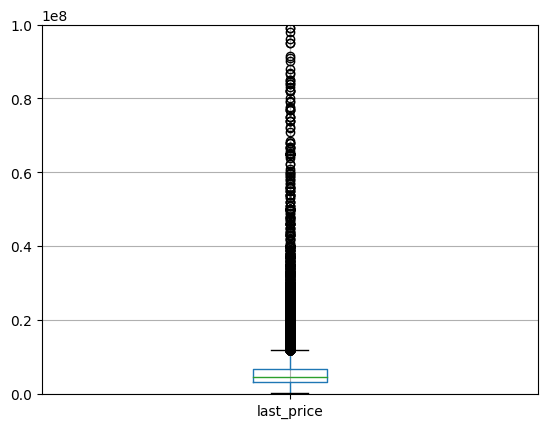

In [46]:
data.boxplot(column=['last_price']) #построим диаграмму размаха для цены
plt.ylim(0,100000000);


Выбросов много, но медиана стремиться к более низким значениям

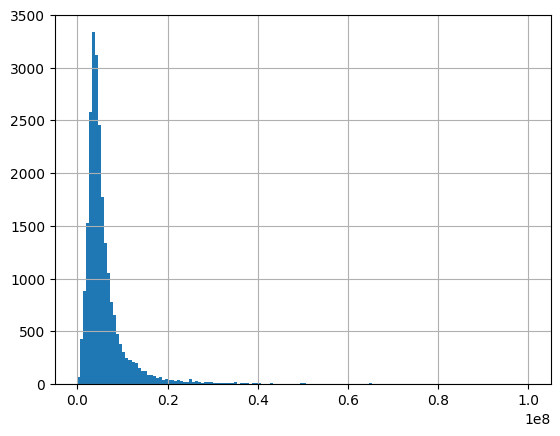

In [47]:
data['last_price'].hist(bins=150,range=(0,100000000));

In [48]:
data.query('last_price > 60_000_000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,NaN,9,False,...,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
155,8,96000000.0,317.0,2017-07-07,4,3.50,3,183.0,3,False,...,NaN,1,Санкт-Петербург,22673.0,1771.0,2.0,508.0,3.0,366.0,62.0
464,15,66571000.0,280.3,2015-06-11,6,5.20,8,159.5,7,False,...,21.1,0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0
492,18,95000000.0,216.0,2017-12-05,4,3.00,5,86.0,4,False,...,77.0,0,Санкт-Петербург,21740.0,436.0,2.0,138.0,3.0,620.0,14.0
509,5,90000000.0,225.0,2016-06-26,6,2.65,4,134.0,2,False,...,19.5,2,Санкт-Петербург,32864.0,5720.0,0.0,NaN,2.0,519.0,416.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22494,7,91075000.0,491.0,2017-05-27,5,4.20,9,274.0,9,False,...,45.0,0,Санкт-Петербург,25525.0,5845.0,2.0,116.0,0.0,NaN,115.0
22804,4,81960000.0,205.0,2017-09-29,4,3.20,9,108.0,3,False,...,10.0,0,Санкт-Петербург,21946.0,2242.0,1.0,679.0,1.0,227.0,169.0
22831,18,289238400.0,187.5,2019-03-19,2,3.37,6,63.7,6,False,...,30.2,0,Санкт-Петербург,22494.0,1073.0,3.0,386.0,3.0,188.0,NaN
22907,9,65000000.0,228.0,2016-06-02,4,2.65,5,200.0,2,False,...,NaN,0,Санкт-Петербург,22783.0,1295.0,3.0,619.0,3.0,269.0,NaN


Удалим эти записи, их не много, а стандартное отклонение станет на порядок меньше.

In [49]:
data = data[data['last_price'] < 60_000_000]

In [50]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23511.000000,2.351100e+04,23511.000000,23511.000000,23511.000000,23511.000000,21656.000000,23511.000000,21297.000000,23511.000000,17983.000000,18004.000000,18005.000000,7968.000000,18005.000000,8976.000000,20358.000000
mean,9.858832,6.059773e+06,59.411086,2.059844,2.722440,10.688146,33.985767,5.877717,10.461070,0.594190,28800.516043,14239.461453,0.605887,491.390437,0.764121,519.914884,180.273603
std,5.675391,5.274253e+06,31.593382,1.058734,0.990707,6.603086,20.126448,4.877188,5.503861,0.960672,12654.799114,8605.132296,0.796619,341.154712,0.934634,277.953814,219.196265
min,0.000000,4.300000e+05,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,0.000000,18539.000000,9327.500000,0.000000,288.000000,0.000000,296.000000,45.000000
50%,9.000000,4.600000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,26758.000000,13138.000000,0.000000,456.000000,0.000000,504.000000,95.000000
75%,14.000000,6.700000e+06,69.100000,3.000000,2.700000,16.000000,42.100000,8.000000,12.000000,1.000000,37310.000000,16298.250000,1.000000,612.000000,1.000000,733.000000,231.000000
max,50.000000,5.991412e+07,517.000000,19.000000,100.000000,60.000000,332.000000,33.000000,100.700000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [51]:
data['rooms'].unique() # в уникальных значениях столбца с количеством комнат есть подозрительные значения больше 10

array([ 3,  1,  2,  4,  5,  6,  0, 11,  7,  8, 14, 10,  9, 19, 16],
      dtype=int64)

In [52]:
data.query('rooms >10') #проверим квартиры с большим количеством комнат

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
648,3,17500000.0,183.7,2018-07-01,11,3.40,7,138.8,7,False,...,13.3,0,Санкт-Петербург,23606.0,3148.0,0.0,NaN,0.0,NaN,NaN
866,5,25000000.0,363.0,2017-12-23,14,3.16,5,222.0,4,False,...,16.6,0,Санкт-Петербург,38076.0,7950.0,0.0,NaN,2.0,435.0,418.0
9688,8,33000000.0,194.1,2017-02-07,11,3.43,5,129.0,2,False,...,11.9,0,Санкт-Петербург,21469.0,1015.0,1.0,686.0,2.0,66.0,813.0
14498,6,32250000.0,374.6,2018-06-09,19,2.65,5,264.5,2,False,...,27.6,0,Санкт-Петербург,19497.0,3574.0,0.0,NaN,2.0,548.0,114.0
18848,6,28500000.0,270.0,2015-03-02,16,3.00,4,180.0,4,False,...,13.0,1,Санкт-Петербург,23575.0,4142.0,1.0,516.0,0.0,NaN,1365.0
20829,6,28659000.0,245.4,2016-03-31,14,2.65,4,168.3,2,False,...,25.9,0,Санкт-Петербург,21104.0,2054.0,3.0,541.0,2.0,118.0,95.0


Большие по площадям квартиры имеют много комнат, ничего криминального.

In [53]:
data['ceiling_height'].unique() #просмотрим уникальные значения столбца с высотой потолков

array([  2.7 ,   2.65,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   3.2 ,   2.61,   3.25,
         3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.3 ,   2.71,
         4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,   3.4 ,   3.5 ,
         3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,   2.58,
         3.7 ,   2.52,   2.87,   2.66,   2.59,   2.  ,   2.45,   3.6 ,
         2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,   3.16,   3.62,
         3.12,   2.53,   2.74,   2.96,   2.46,   5.  ,   2.79,   2.95,
         4.06,   2.94,   3.54,   3.53,   2.83,   2.4 ,   3.38,   3.01,
         5.6 ,   3.65,   3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,
         2.82,   3.98,   2.63,   3.83,   3.52,   3.95,   3.75,   2.88,
         3.67,   3.87,   3.66,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,
         4.2 ,   3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,
         8.  ,   3.26,   3.34,   2.81,   3.44,   2.97,   3.14,   4.37,
      

Есть выбивающиеся неправдоподобные значения высоты потолков, скорее всего опечатки при заполнении пользователями.

In [54]:
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height']<=10, data['ceiling_height']/10)
#перезапишем значения высоты, если оно больше 10м включительно, на значение, уменьшенное в 10 раз

In [55]:
data['ceiling_height'].unique() # проверим отсутсвие выбивающихся значений

array([ 2.7 ,  2.65,  3.03,  2.5 ,  2.67,  2.56,  3.05,  2.75,  2.6 ,
        2.9 ,  2.8 ,  2.55,  3.  ,  3.2 ,  2.61,  3.25,  3.45,  2.77,
        2.85,  2.64,  2.57,  4.15,  3.3 ,  2.71,  4.  ,  2.47,  2.73,
        2.84,  3.1 ,  2.34,  3.4 ,  3.5 ,  3.06,  2.72,  2.54,  2.51,
        2.78,  2.76,  2.58,  3.7 ,  2.52,  2.87,  2.66,  2.59,  2.  ,
        2.45,  3.6 ,  2.92,  3.11,  3.13,  3.8 ,  3.15,  3.55,  3.16,
        3.62,  3.12,  2.53,  2.74,  2.96,  2.46,  5.  ,  2.79,  2.95,
        4.06,  2.94,  3.54,  3.53,  2.83,  2.4 ,  3.38,  3.01,  5.6 ,
        3.65,  3.18,  3.35,  2.3 ,  3.57,  2.48,  2.62,  2.82,  3.98,
        2.63,  3.83,  3.52,  3.95,  3.75,  2.88,  3.67,  3.87,  3.66,
        3.86,  4.19,  3.24,  4.8 ,  4.5 ,  4.2 ,  3.36,  3.08,  3.68,
        3.07,  3.37,  3.09,  8.  ,  3.26,  3.34,  2.81,  3.44,  2.97,
        3.14,  4.37,  2.68,  3.9 ,  3.22,  3.27,  4.1 ,  2.93,  3.46,
        3.47,  3.33,  3.63,  3.32,  1.2 ,  8.3 ,  2.98,  2.86,  3.17,
        4.4 ,  3.28,

In [56]:
data['floors_total'].unique() #уникальные значения общей этажности жилого здания

array([16, 11,  5, 14, 12, 26, 24, 27,  9,  6, 17, 25,  3, 23, 19, 18,  4,
       22,  8,  2, 10,  7, 13, 15, 20, 28, 36, 21, 35, 34, 60,  1, 29, 33,
       52, 37])

In [57]:
data.query('floors_total > 37') #посмотрим записи с подозрительными значениями высотности здания

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2253,12,3800000.0,45.5,2018-06-28,2,2.88,60,27.4,4,False,...,7.4,0,Кронштадт,67763.0,49488.0,2.0,342.0,3.0,614.0,166.0
16731,9,3978000.0,40.0,2018-09-24,1,2.65,52,10.5,18,False,...,14.0,0,Санкт-Петербург,20728.0,12978.0,1.0,793.0,0.0,NaN,45.0


Самое высокое жилое здание в Санкт-Петербурге имеет 37 этажей, больше этого - скорее всего ошибка при заполнении. Удалим эти записи.

In [58]:
data = data[data['floors_total'] != 60] #удалим записи с этажностью больше 37 этажей
data = data[data['floors_total'] != 52] 

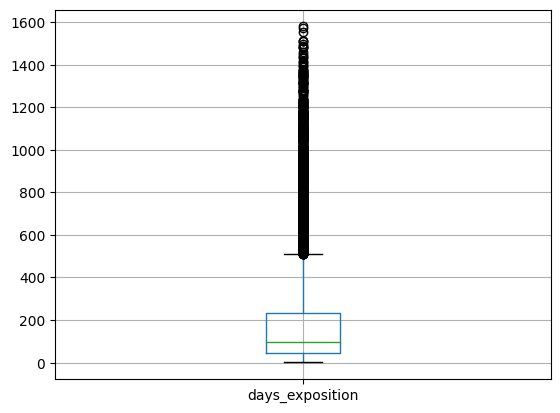

In [59]:
data.boxplot(column=['days_exposition']); # посмотрим диаграмму размаха для количества дней размещения объявления

Среднее значение для этого столбца - 180 дней, в то время как медианное - 95, подозрительно?

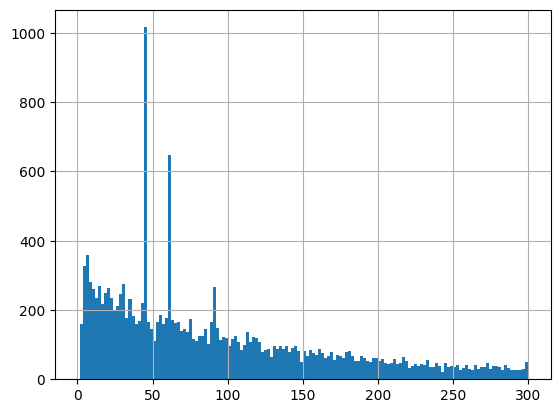

In [60]:
data['days_exposition'].hist(bins=150, range=(0,300)); #рассмотрим поближе гистограмму по количеству дней публикации

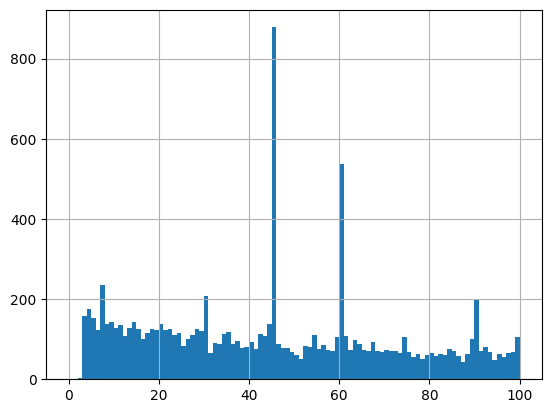

In [61]:
data['days_exposition'].hist(bins=100, range=(0,100));  #рассмотрим еще ближе

Виден пик около 45 и 60 дней. Стоит просмотреть срезы по этим дням.

In [62]:
data.query('days_exposition == 45') # срез данных по количеству дней публикации равном 45

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
78,9,4350000.0,37.0,2018-02-22,1,2.65,19,18.0,6,False,...,10.7,0,Санкт-Петербург,34324.0,14192.0,0.0,NaN,0.0,NaN,45.0
89,9,2500000.0,63.0,2018-10-25,3,2.50,5,43.0,4,False,...,9.0,0,Сиверский,NaN,NaN,NaN,NaN,NaN,NaN,45.0
110,6,3850000.0,72.3,2017-09-29,2,2.65,3,27.4,2,False,...,23.6,0,Пикколово,NaN,NaN,NaN,NaN,NaN,NaN,45.0
153,12,4350000.0,55.0,2017-05-21,2,2.57,9,31.2,2,False,...,8.3,0,Петергоф,45958.0,34425.0,1.0,589.0,0.0,NaN,45.0
158,15,3100000.0,47.3,2017-11-07,2,2.65,5,27.5,2,False,...,8.5,0,Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23601,10,2900000.0,43.4,2018-01-11,2,2.65,5,NaN,1,False,...,NaN,0,Санкт-Петербург,22001.0,14193.0,1.0,202.0,2.0,397.0,45.0
23613,4,3950000.0,52.0,2018-03-04,3,2.65,5,NaN,2,False,...,NaN,0,Парголово,55549.0,21223.0,0.0,NaN,0.0,NaN,45.0
23670,9,2450000.0,45.6,2018-02-08,1,2.80,9,NaN,2,False,...,NaN,0,Синявино,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23679,0,2500000.0,35.0,2017-12-08,1,2.65,9,NaN,4,False,...,NaN,0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.0


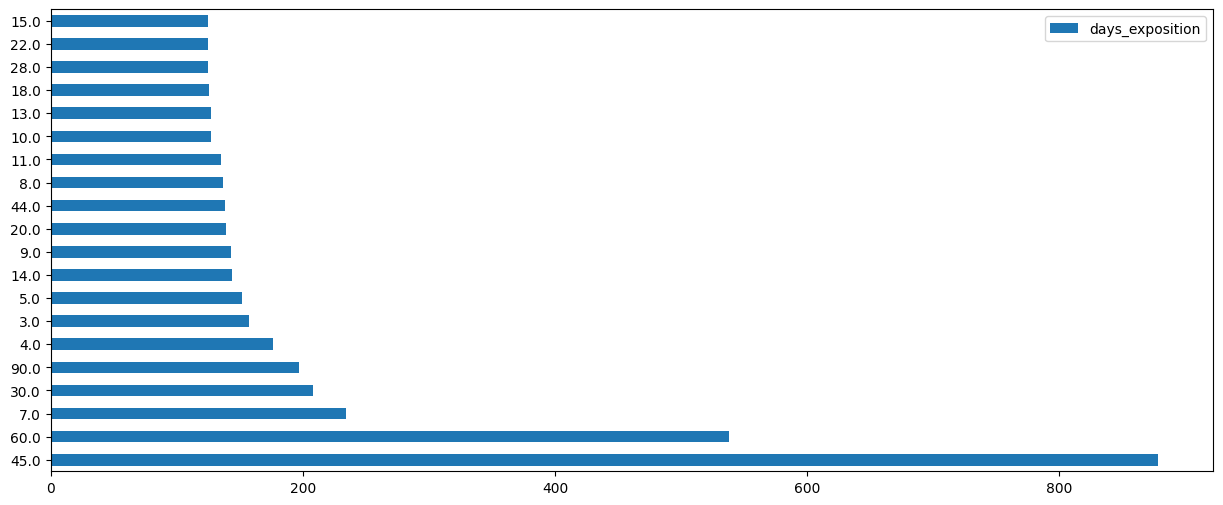

In [63]:
data['days_exposition'].value_counts().to_frame().head(20).plot(kind = 'barh', figsize = (15,6), rot = 0);

Не совсем понятно, в чем причина этого большого количества квартир со сроком публикации в 45 дней и в 60. Возможно, так работает автоматическая система, скрывая объявления без активности. 

In [64]:
data_without45_60_days = data.loc[((data['days_exposition']!=45) & (data['days_exposition']!=60))] 

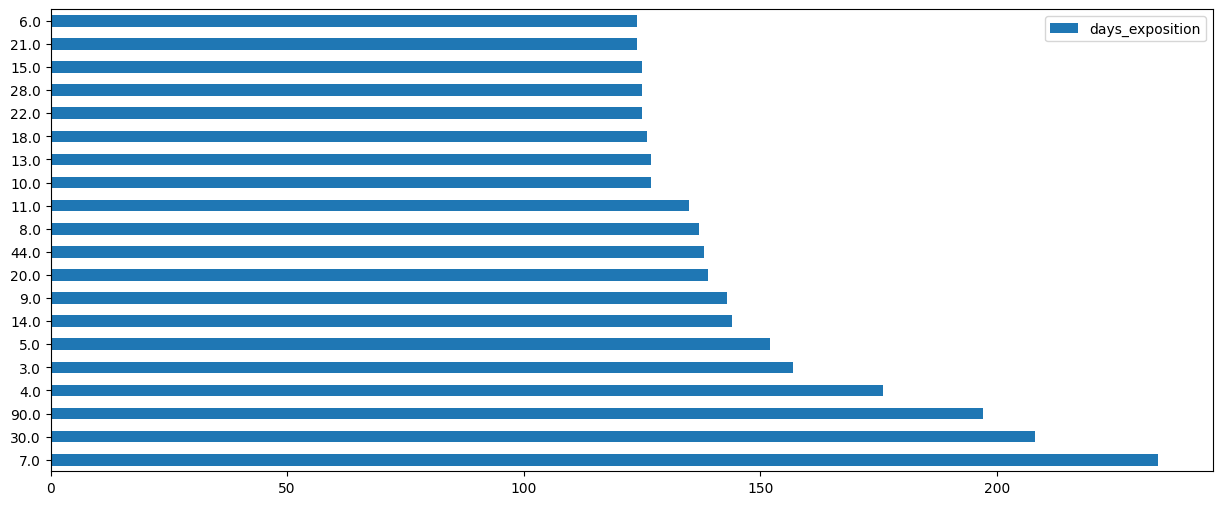

In [65]:
# моды на данных, в которых исключены 45 и 60 дни
data_without45_60_days['days_exposition'].value_counts().to_frame().head(20).plot(kind = 'barh', figsize = (15,6), rot = 0);

**Вывод:**
<div style="border: solid pink 2px; padding: 20px">

- выбросы в сторону больших цен скорее всего оправданы, ведь это недвижимость и мы не знаем, как например оснащена эта квартира и какой там ремонт, поэтому стоит скорее не отбрасывать данные с большой ценой, а рассматривать квартиры по разным ценовым промежуткам;
- поле с вводом высоты потолков стоит ограничить высотой до 10 метров;
- так же возможно стоит ограничить выбор этажности дома;
- причину выбросов, связанных с 45 и 60 днями публикаций, определить не удалось, возможно стоит получить какие-то дополнительные данные;
- при исключении этих записей выяснилось, что чаще всего квартиры продают на 7, 30 и 90 дни

### Проверка оставшихся аномалий

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23509 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23509 non-null  int64         
 1   last_price            23509 non-null  float64       
 2   total_area            23509 non-null  float64       
 3   first_day_exposition  23509 non-null  datetime64[ns]
 4   rooms                 23509 non-null  int64         
 5   ceiling_height        23509 non-null  float64       
 6   floors_total          23509 non-null  int32         
 7   living_area           21654 non-null  float64       
 8   floor                 23509 non-null  int64         
 9   is_apartment          23509 non-null  bool          
 10  studio                23509 non-null  bool          
 11  open_plan             23509 non-null  bool          
 12  kitchen_area          21295 non-null  float64       
 13  balcony         

In [67]:
# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные
data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area', 'kitchen_area',
          'floor', 'floors_total']].apply (['count', 'min', 'max', 'mean','median']).style.format("{:,.2f}")

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,509.00","23,509.00","23,509.00","20,356.00","23,509.00","21,654.00","21,295.00","23,509.00","23,509.00"
min,0.00,12.00,1.00,1.00,"430,000.00",2.00,1.30,1.00,1.00
max,19.00,517.00,10.00,"1,580.00","59,914,124.00",332.00,100.70,33.00,37.00
mean,2.06,59.41,2.70,180.28,"6,059,957.35",33.99,10.46,5.88,10.68
median,2.00,52.00,2.65,95.00,"4,600,000.00",30.00,9.10,4.00,9.00


Остались аномалии и редкости (в т.ч. и хвосты) в колонках: 'rooms', 'total_area', 'ceiling_height', 'days_exposition',   'living_area',  'kitchen_area'        


In [68]:
data.rooms.value_counts().to_frame().head()

,rooms
1,8014
2,7908
3,5771
4,1151
5,303


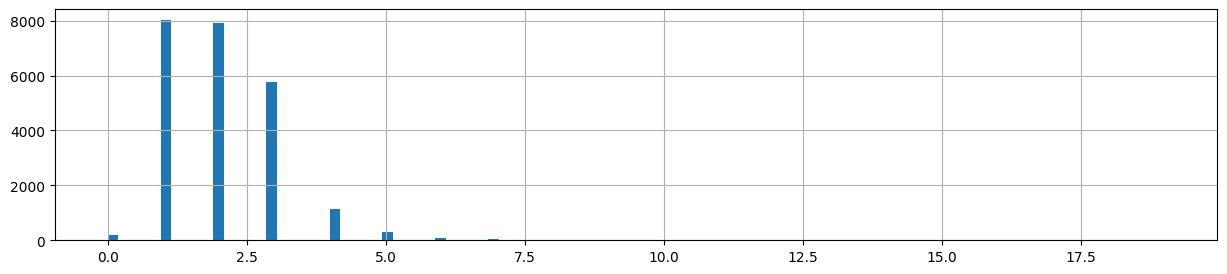

In [69]:
data.rooms.hist(bins=100, figsize = (15,3));

In [70]:
data.query('rooms > 5')['rooms'].count()

169

In [71]:
data = data.loc[((data['rooms'] <=5) | (data['rooms'].isna()))] 

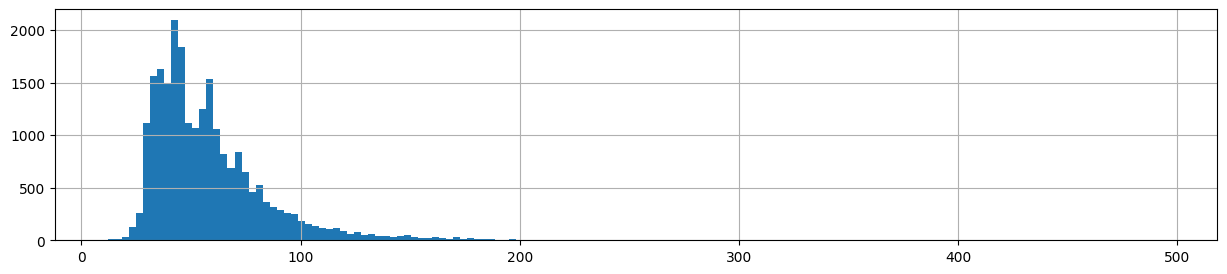

In [72]:
data.total_area.hist(bins = 150, figsize = (15,3));

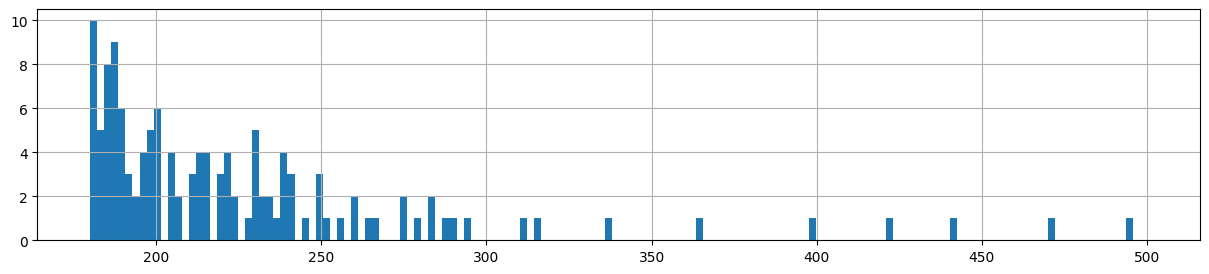

In [73]:
data.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

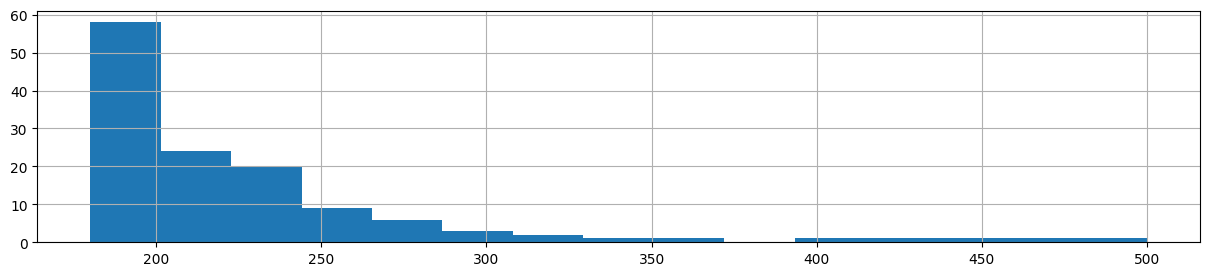

In [74]:
data.total_area.hist(bins = 15, figsize = (15,3), range = (180,500));

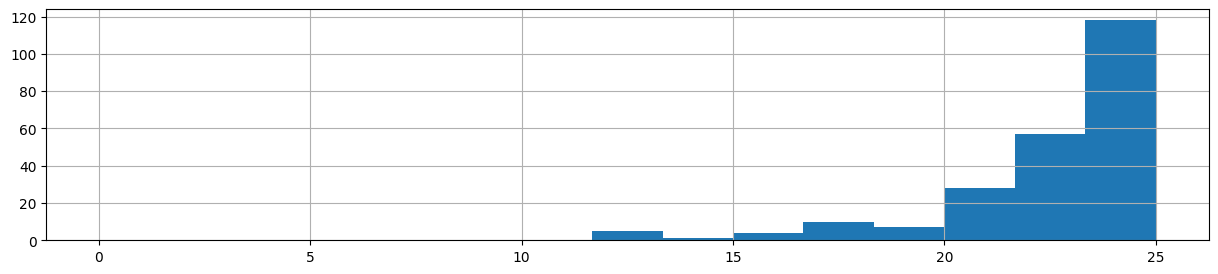

In [75]:
data.total_area.hist(bins = 15, figsize = (15,3), range = (0,25));

In [76]:
data.query('(total_area < 20) | (total_area > 250)')['total_area'].count()

51

In [77]:
data = data.loc[((data['total_area'] >=20 ) | (data['total_area'].isna()))] 

In [78]:
data = data.loc[((data['total_area'] <=250 ) | (data['total_area'].isna()))] 

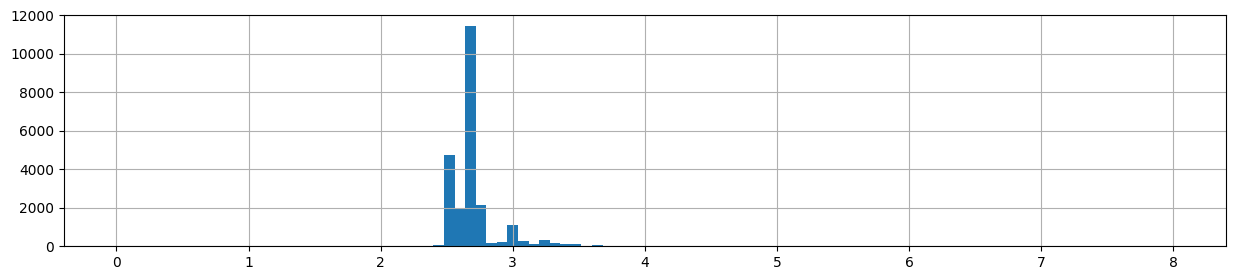

In [79]:
data.ceiling_height.hist(bins = 100, figsize = (15,3), range = (0,8));

In [80]:
data.query('(ceiling_height < 2) | (ceiling_height > 4)')['ceiling_height'].count()

43

In [81]:
data = data.loc[((data['ceiling_height'] >= 2 ) | (data['ceiling_height'].isna()))] 

In [82]:
data = data.loc[((data['ceiling_height'] <= 4 ) | (data['ceiling_height'].isna()))] 

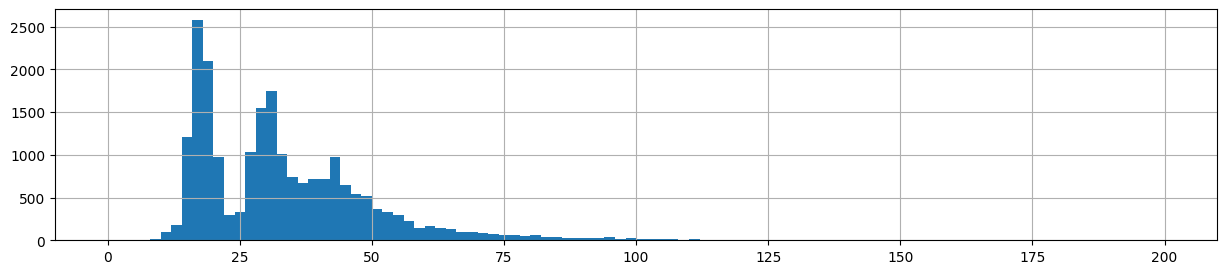

In [83]:
data.living_area.hist(bins = 100, figsize = (15,3), range=(0, 200));

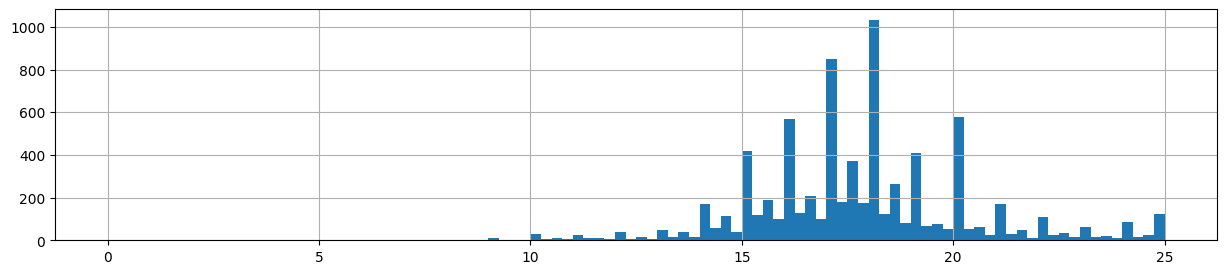

In [84]:
data.living_area.hist(bins = 100, figsize = (15,3), range=(0, 25));

In [85]:
data.query('(living_area < 10) | (living_area > 100)')['living_area'].count()

167

In [86]:
data = data.loc[((data['living_area'] >= 10 ) | (data['living_area'].isna()))] 

In [87]:
data = data.loc[((data['living_area'] <= 100 ) | (data['living_area'].isna()))] 

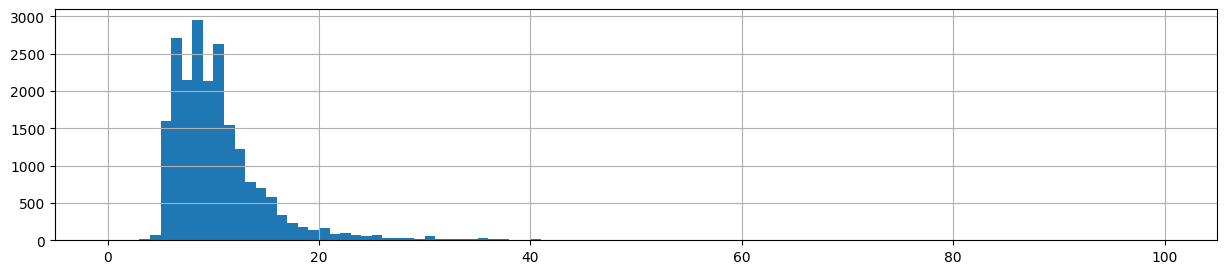

In [88]:
data.kitchen_area.hist(bins = 100, figsize = (15,3), range=(0, 100));

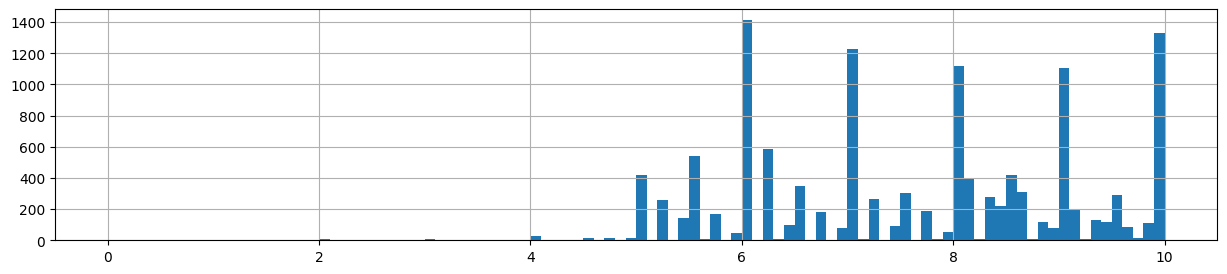

In [89]:
data.kitchen_area.hist(bins = 100, figsize = (15,3), range=(0, 10));

In [90]:
data.query('kitchen_area > 30')['kitchen_area'].count()

237

In [91]:
data = data.loc[((data['kitchen_area'] <=30) | (data['kitchen_area'].isna()))] 

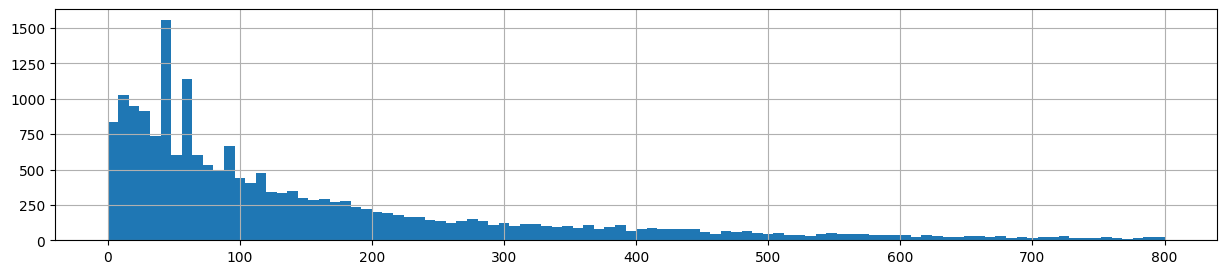

In [92]:
data.days_exposition.hist(bins = 100, figsize = (15,3), range=(0,800));

In [93]:
data.query('(days_exposition > 1000)')['days_exposition'].count()

249

In [94]:
data = data.loc[((data['days_exposition'] <=1000) | (data['days_exposition'].isna()))] 

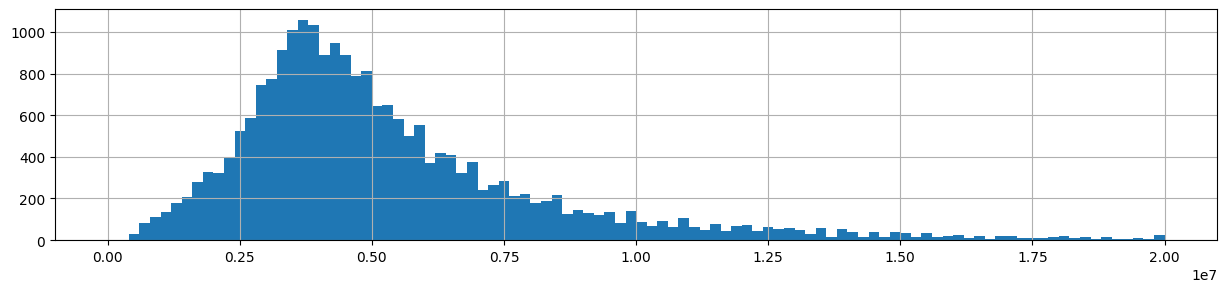

In [95]:
data.last_price.hist(bins = 100, figsize = (15,3), range=(0, 20_000_000));

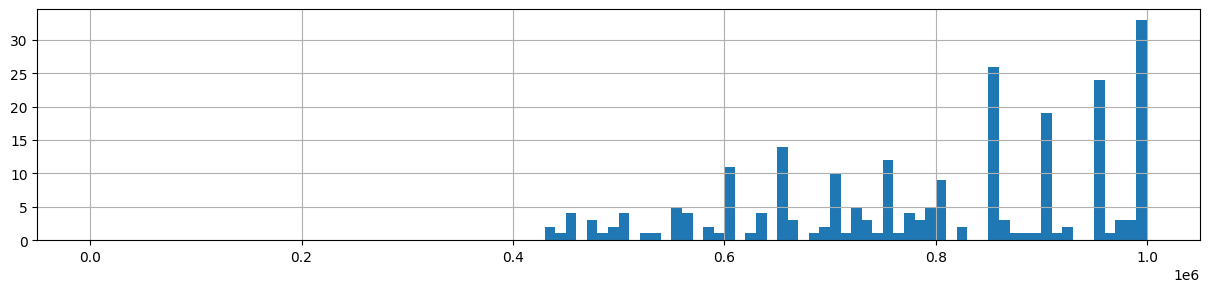

In [96]:
data.last_price.hist(bins = 100, figsize = (15,3), range=(0, 1_000_000));

In [97]:
data.query('(last_price < 400_000) | (last_price > 16_000_000)')['last_price'].count()

568

In [98]:
data = data.loc[((data['last_price'] >= 400_000 ) | (data['last_price'].isna()))] 

In [99]:
data = data.loc[((data['living_area'] <= 16_000_000 ) | (data['living_area'].isna()))] 

In [100]:
data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area', 'kitchen_area','floor', 'floors_total']]\
.apply(['count', 'min', 'max']).style.format("{:,.2f}")

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,593.00","22,593.00","22,593.00","19,611.00","22,593.00","20,804.00","20,447.00","22,593.00","22,593.00"
min,0.00,20.00,2.00,1.00,"430,000.00",10.00,1.30,1.00,1.00
max,5.00,240.00,4.00,"1,000.00","59,534,892.00",100.00,30.00,33.00,36.00


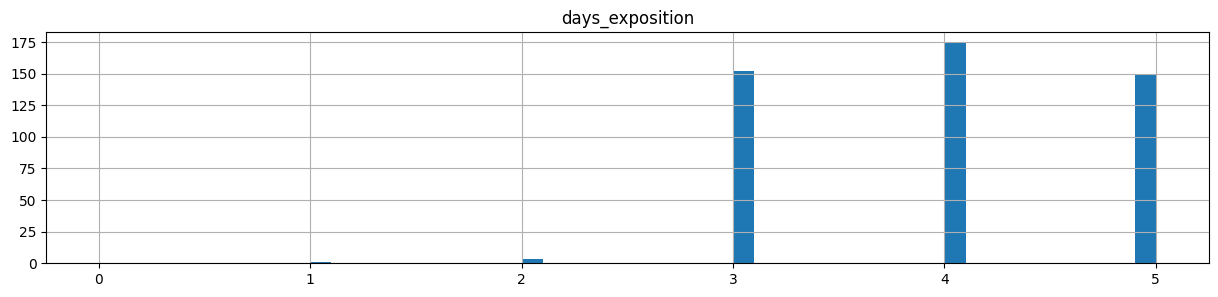

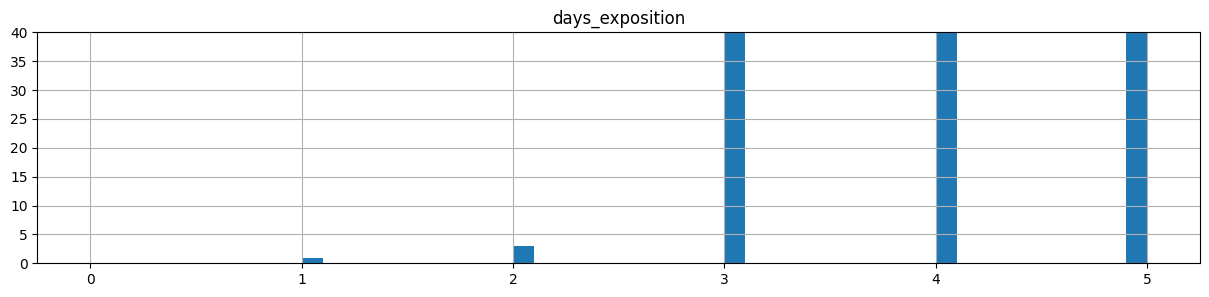

In [101]:
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5))
plt.ylim(0, 40);

In [102]:
# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0012,0.00,21.71,2.40,3.00,"566,656.00",10.00,4.00,1.00,2.00
0.01,1.00,26.00,2.50,4.00,"1,000,000.00",13.27,5.00,1.00,2.00
0.5,2.00,51.00,2.65,92.00,"4,550,000.00",30.00,9.00,4.00,9.00
0.99,4.00,139.61,3.50,859.00,"23,300,000.00",83.19,25.00,23.00,26.00
0.9988,5.00,185.89,4.00,977.00,"43,857,054.40",98.00,30.00,26.00,33.89


Видно, что остались хвосты в общей площади и цене, но если их убрать, придется вырезать большее количество записей чем 1% от исходного количества на колонку.

In [103]:
# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# урезанные данные
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max', 'mean', 'median'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,593.00","22,593.00","22,593.00","19,611.00","22,593.00","20,804.00","20,447.00","22,593.00","22,593.00"
min,0.00,20.00,2.00,1.00,"430,000.00",10.00,1.30,1.00,1.00
max,5.00,240.00,4.00,"1,000.00","59,534,892.00",100.00,30.00,33.00,36.00
mean,2.00,56.52,2.68,165.17,"5,627,412.02",32.29,9.93,5.90,10.75
median,2.00,51.00,2.65,92.00,"4,550,000.00",30.00,9.00,4.00,9.00


Видно, что медианные значения практически не изменились, максимальные практически везде стали меньше, средние значения стали ближе к медианным.

## Посчитайте и добавьте в таблицу новые столбцы

#### Столбец с ценой одного квадратного метра

Добавим столбец price_per_m2, содержащий цену одного квадратного метра для каждого объявления.

In [104]:
data['price_per_m2'] = data['last_price']/data['total_area'] 

#### Столбец с днем недели публикации объявления

Добавим столбец day_of_week, содержащий день недели публикации каждого объявления.

In [105]:
data['day_of_week'] = data['first_day_exposition'].dt.weekday

#### Столбец с месяцем публикации объявления

Добавим столбец publication_month, содержащий месяц публикации каждого объявления.

In [106]:
data['publication_month'] = pd.DatetimeIndex(data['first_day_exposition']).month

#### Столбец с годом публикации объявления

Добавим столбец publication_year, содержащий год публикации каждого объявления.

In [107]:
data['publication_year'] = pd.DatetimeIndex(data['first_day_exposition']).year

#### Столбец с типом этажа квартиры

Создадим временный столбец для функции, которая будет определять тип этажа по разности этажей, кроме первого, который определим сразу в этом столбце

In [108]:
data['temp_floor_type'] = (data['floors_total'] - data['floor']).where(data['floor']!=1, 'первый')

In [109]:
def determinant_floor_type(floor): # функция, возвращающая тип этажа
    if floor == 'первый':
        return 'первый'
    elif 0 <= floor < 1:
        return 'последний'
    elif floor < 0:
        return 'ошибка'
    return 'другой'

# если в floors_total пропуск, то этаж будет определяться как 'другой'

Применяем функцию determinant_floor_type к временному столбцу temp_floor_type для получения требуемого столбца с типом этажа квартиры floor_type

In [110]:
data['floor_type'] = data['temp_floor_type'].apply(determinant_floor_type) 

In [111]:
data = data.drop(columns = ['temp_floor_type'], axis = 1) # удаляем временный столбец temp_floor_type

Проверим, нет ли где то этажа квартиры выше, чем сам дом.

In [112]:
data.query('floor_type == "ошибка"') 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,day_of_week,publication_month,publication_year,floor_type


#### Столбец с расстоянием до центра города в километрах

Добавим столбец cityCenters_nearest_km, содержащий расстояние до центра, выраженное в километрах.

In [113]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest']/1000 

In [114]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].apply(to_round) 
# перезаписываем столбец с километрами целыми значениями, используя функцию, описанную выше в 2.2

Проверяем наличие всех новых столбцов в таблице

In [115]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,day_of_week,publication_month,publication_year,floor_type,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый,18.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой,13.0
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,NaN,NaN,NaN,55.0,95065.789474,0,9,2018,другой,NaN
6,6,3700000.0,37.3,2017-11-02,1,2.65,26,10.6,6,False,...,NaN,0.0,NaN,155.0,99195.710456,3,11,2017,другой,19.0


## Проведите исследовательский анализ данных

### Изучите следующие параметры объектов

#### Общая площадь

Построим гистограмму для общей площади всех квартир

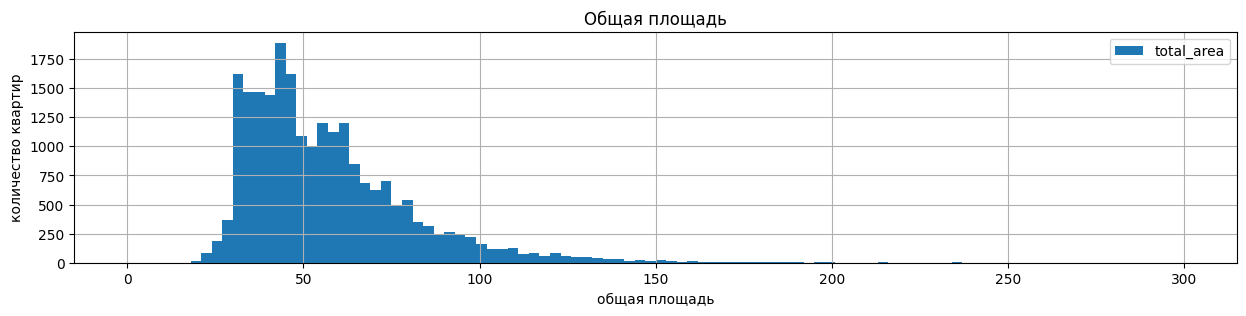

In [116]:
data.plot(y='total_area', kind='hist', bins=100, figsize = (15,3), grid=True, range=(0,300), title='Общая площадь')\
.set(xlabel='общая площадь', ylabel='количество квартир');

У гистограммы есть три пика, однако для общей площади квартир это нормально, много квартир построено по одинаковым планировкам и с одинаковыми площадями.

####  Жилая площадь

Гистограмма для жилой площади у всех квартир

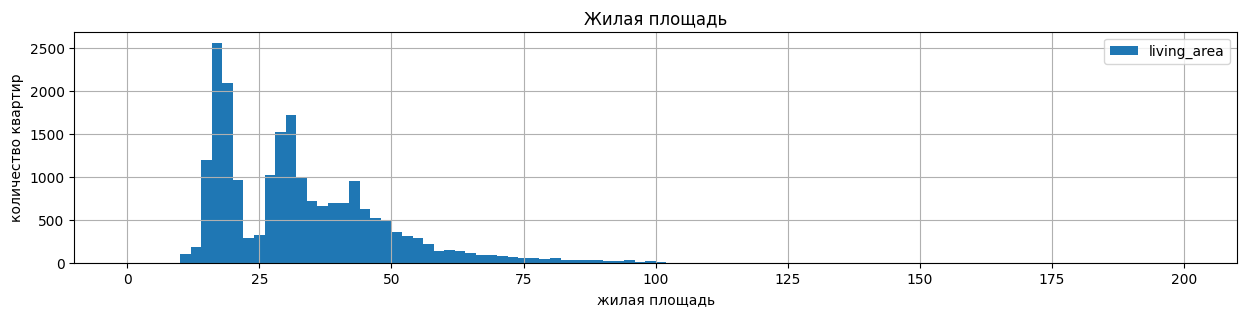

In [117]:
data.plot(y='living_area', kind='hist', bins=100, figsize = (15,3), grid=True, range=(0,200), title='Жилая площадь')\
.set(xlabel='жилая площадь', ylabel='количество квартир');

Опять же, три явных пика, что подтверждает то, что это три вида стандартных квартир (1, 2, и 3-х комнатные)

#### Площадь кухни

Гистограмма для площади кухни для всех квартир

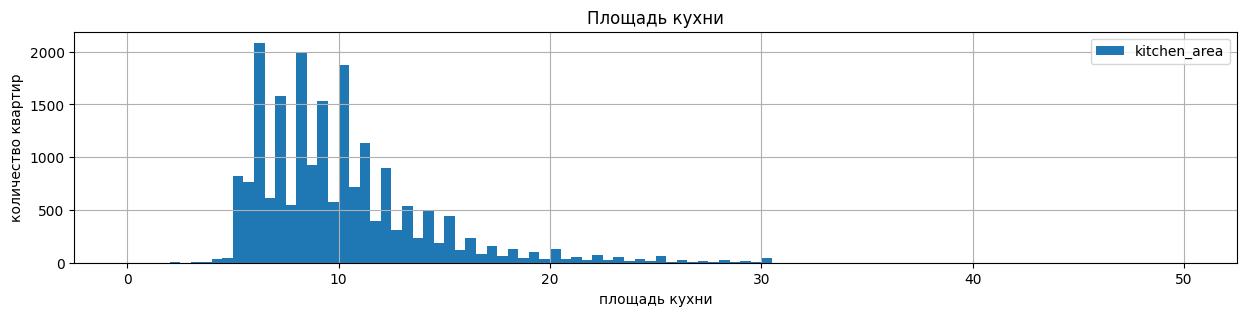

In [118]:
data.plot(y='kitchen_area', kind='hist', bins=100, figsize = (15,3), grid=True, range=(0,50), title='Площадь кухни')\
.set(xlabel='площадь кухни', ylabel='количество квартир');

У гистограммы есть пики около 5-15 метров квадратых, и плавный спад. Похоже на правду, кухни чаще всего бывают около 7-12 метров.

#### Цена объекта

Построим гистограмму для последней указанной цены всех квартир

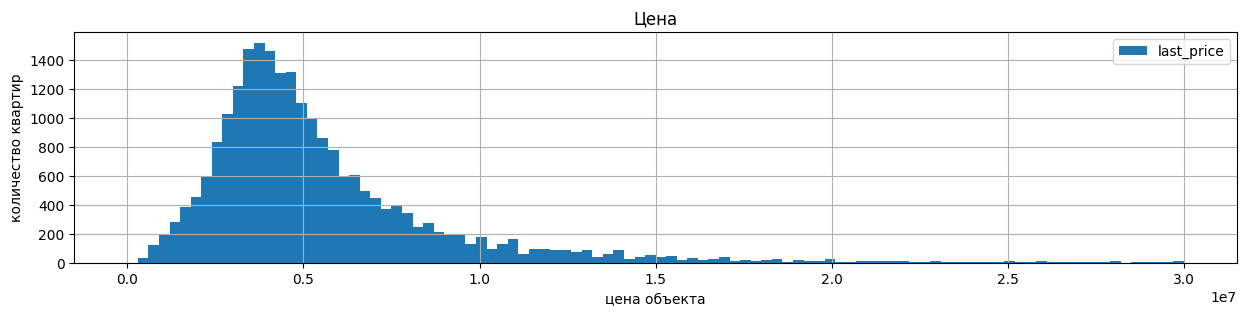

In [119]:
data.plot(y='last_price', kind='hist', bins=100, figsize = (15,3), grid=True, range=(0,30000000), title='Цена')\
.set(xlabel='цена объекта', ylabel='количество квартир');

Гистрограмма имеет плавный вид, немного растянута к большим значениям цены, для недвижимости это выглядит разумно.

#### Количество комнат

Гистограмма для количества комнат во всех квартирах

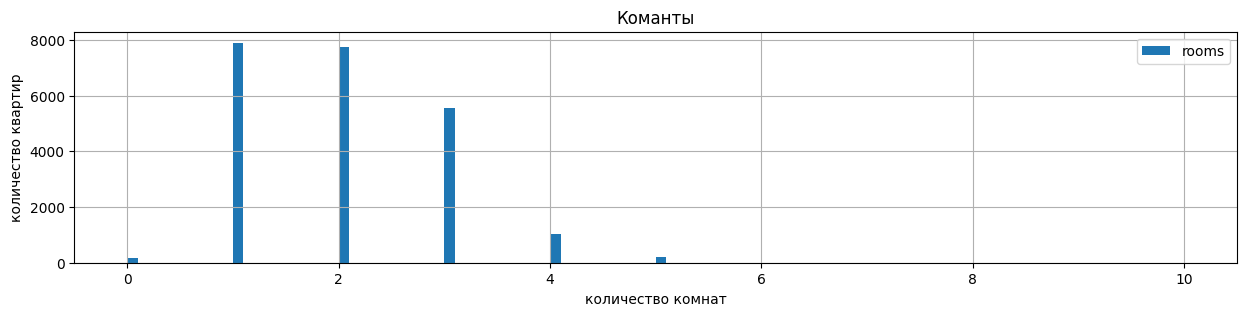

In [120]:
data.plot(y='rooms', kind='hist', bins=100, figsize = (15,3), grid=True, range=(0,10), title='Команты')\
.set(xlabel='количество комнат', ylabel='количество квартир');

Видно, что большинство квартир - однокомнатные и двухкомантные, также много трехкомнатных квартир. Гистограмма также подтверждает теорию о том, что три пика общей площади связаны с стандартными планировками квартир.

####  Высота потолков

Гистограмма для высоты потолков во всех квартирах

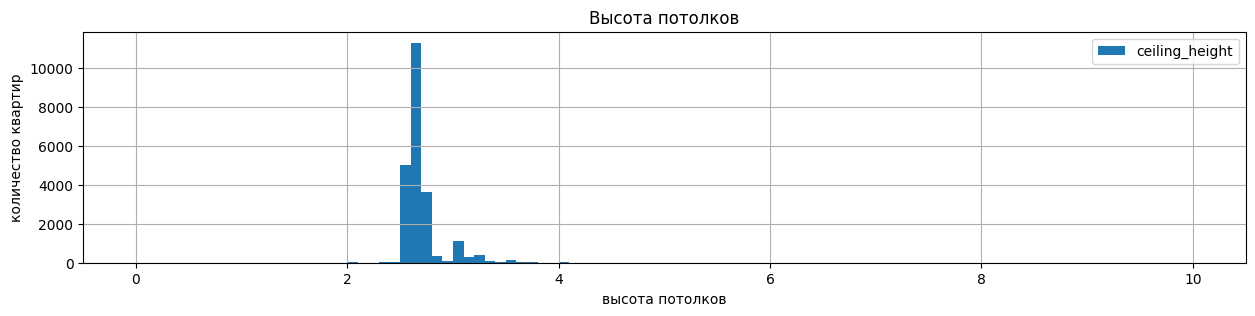

In [121]:
data.plot(y='ceiling_height', kind='hist', bins=100, figsize = (15,3), grid=True, range=(0,10), title='Высота потолков')\
.set(xlabel='высота потолков', ylabel='количество квартир');

В основном все квартиры имеют потолки около 2-4 метров, что соответствует действительности, высокий пик около среднего получился из-за заполнения медианным значением пропусков в столбце с высотой потолков.

#### Этаж квартиры

Гистограмма распредления всех квартир в объявлениях по этажам

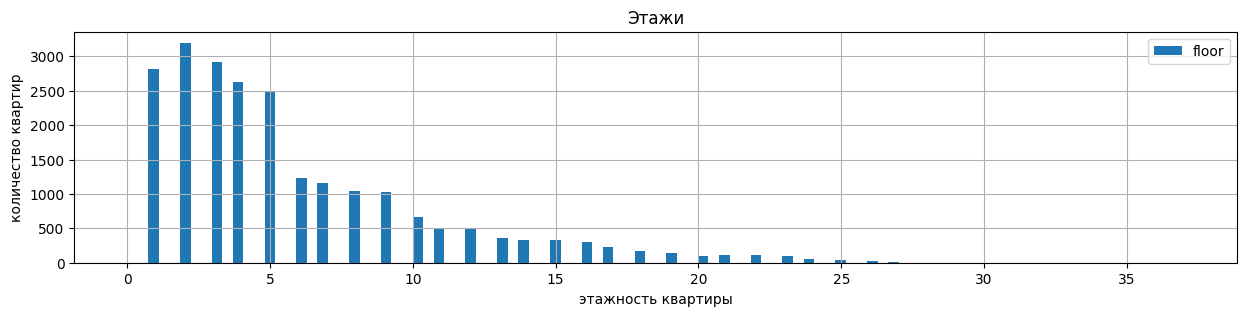

In [122]:
data.plot(y='floor', kind='hist', bins=100, figsize = (15,3), grid=True, range=(0,37), title='Этажи')\
.set(xlabel='этажность квартиры', ylabel='количество квартир');

По гистограмме видно, что большинство объявлений с квартирами, которые находятся от первого до пятого этажа, дальше происходит спад. Вероятнее всего это связанно с особенностями застройки, ведь в небольших городах не строят высокоэтажные дома, да и в целом строительство высоких домов началось гораздо позже, чем, например двухэтажных или пятиэтажных, выглядит правдоподобно.

#### Тип этажа квартиры («первый», «последний», «другой»)

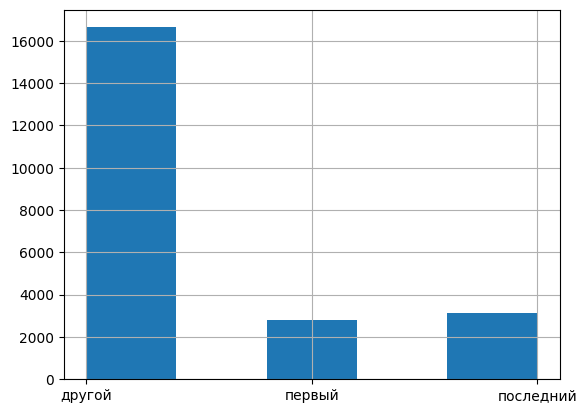

In [123]:
data['floor_type'].hist(bins=5);

Можно сказать, что есть небольшая разница в количестве квартир, находящихся на последнем этаже дома и на первом, в сторону последних этажей. Ожидаемо, что большинство квартир находятся на других этажах, учитывая разнообразие этажей.

#### Общее количество этажей в доме

Гистограмма распредления всех квартир в объявлениях по этажности домов, в которых они находятся

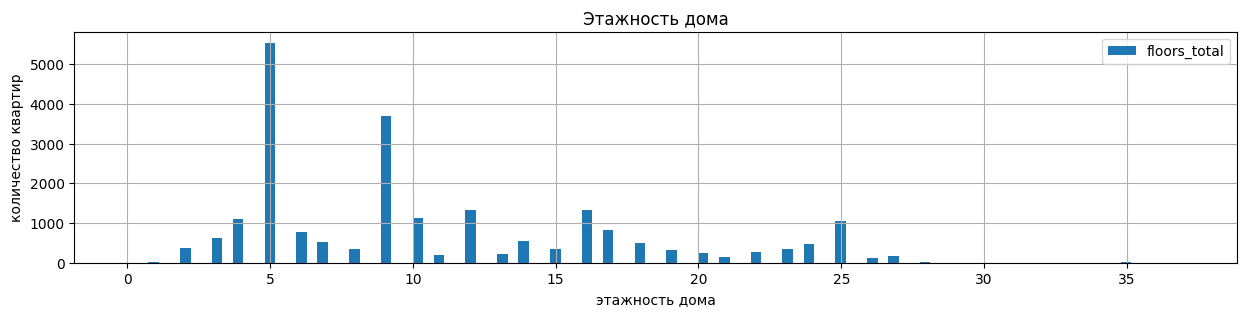

In [124]:
data.plot(y='floors_total', kind='hist', bins=100, figsize = (15,3), grid=True, range=(0,37), title='Этажность дома')\
.set(xlabel='этажность дома', ylabel='количество квартир');

Видно, что большинство это пятиэтажные дома, что сходится с пиком гистограммы по этажности самой квартиры. Так же видно что много девятиэтажных домов.

#### Расстояние до центра города в метрах

Распределение квартир по расстоянию от центра

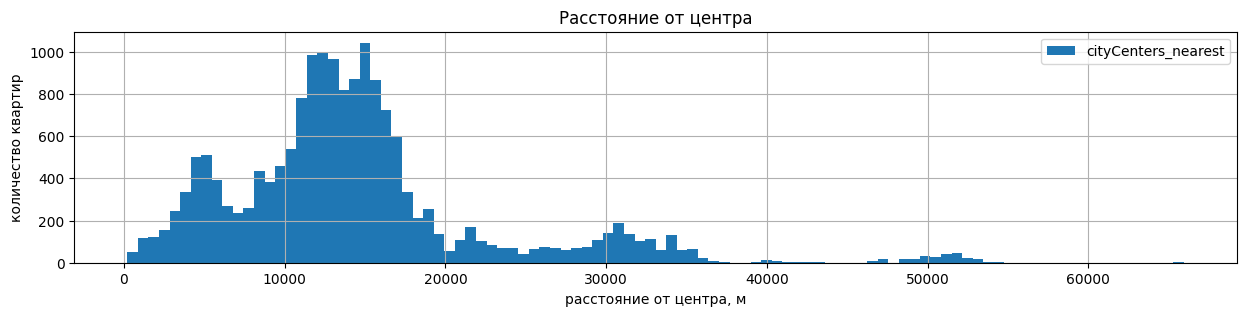

In [125]:
data.plot(y='cityCenters_nearest', kind='hist', bins=100, figsize = (15,3), grid=True, title='Расстояние от центра')\
.set(xlabel='расстояние от центра, м', ylabel='количество квартир');

Гистограмма не выглядит плавной, есть пик около 5000 м, высокий пик от 10000 м до 20000 м, и небольшой около 30000 м. Это расстояния до центра города, похоже, что большинство проданных квартир находятся на расстоянии около 15000 м от центра.

####  Расстояние до ближайшего аэропорта

Распределение квартир по расстоянию до аэропорта

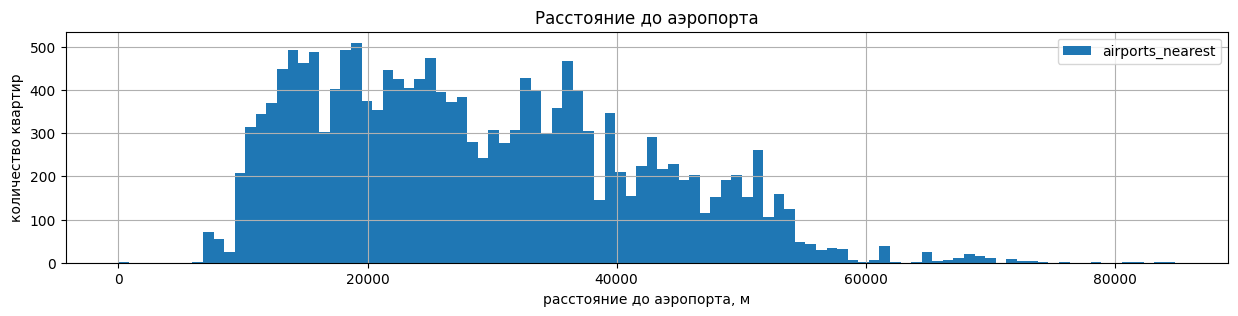

In [126]:
data.plot(y='airports_nearest', kind='hist', bins=100, figsize = (15,3), grid=True, title='Расстояние до аэропорта')\
.set(xlabel='расстояние до аэропорта, м', ylabel='количество квартир');

Тут распределение выглядит более плавно, квартиры располагаются более планомерно от аэропорта, большинство находятся на расстоянии от 20000 м до 40000 м от аэропорта

#### Расстояние до ближайшего парка

Распределение квартир по расстоянию до ближайшего парка

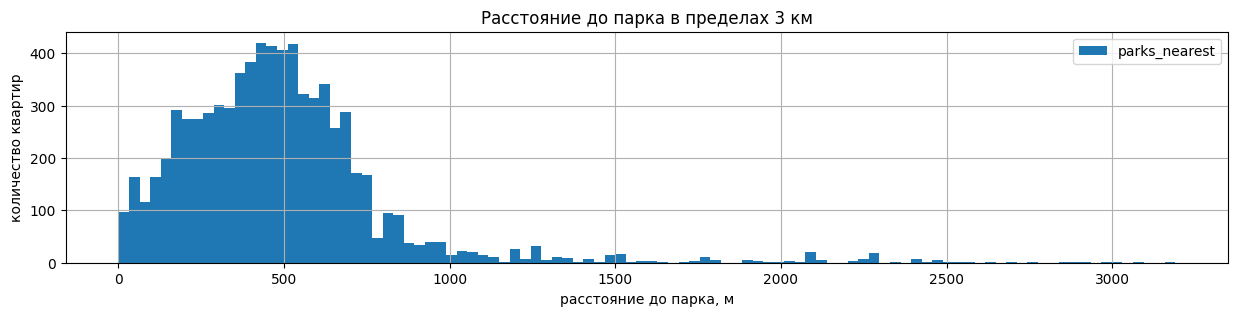

In [127]:
data.plot(y='parks_nearest', kind='hist', bins=100, figsize = (15,3), grid=True, title='Расстояние до парка в пределах 3 км')\
.set(xlabel='расстояние до парка, м', ylabel='количество квартир');

Исходя из квартир, рядом с которым есть парки, в основном они нахоядтся в пределах 1000 метрах.

#### День и месяц публикации объявления

Распределение объявлений по дню недели их публикации 

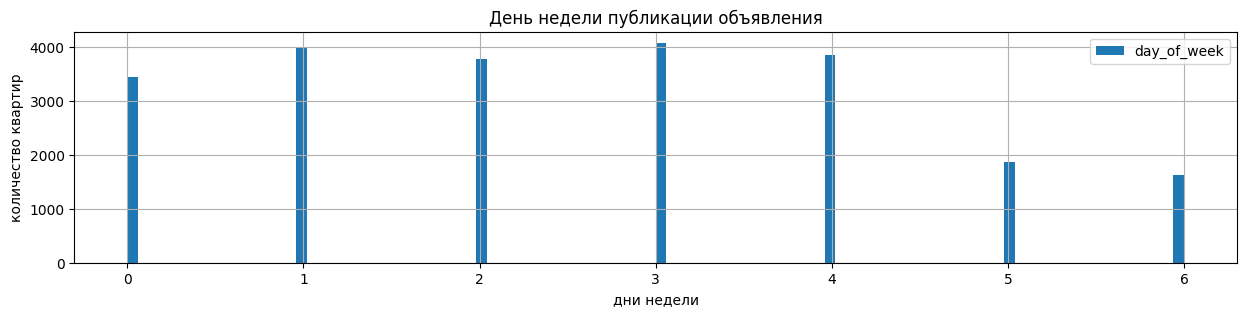

In [128]:
data.plot(y='day_of_week', kind='hist', bins=100, figsize = (15,3), grid=True, title='День недели публикации объявления')\
.set(xlabel='дни недели', ylabel='количество квартир');

На выходных реже всего выкладывают объявления, в будние дни примерно одинаковое количество.

Распределение объявлений по месяцам их публикации 

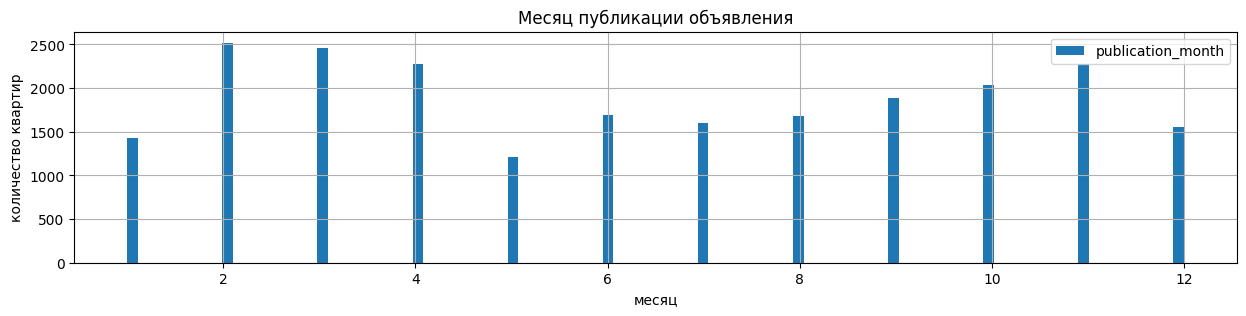

In [129]:
data.plot(y='publication_month', kind='hist', bins=100, figsize = (15,3), grid=True, title='Месяц публикации объявления')\
.set(xlabel='месяц', ylabel='количество квартир');

Чаще выкладывают объявления весной, летом происходит спад, и к зиме снова наблюдается рост, зимой же опять происходит спад.

<div style="border: solid pink 2px; padding: 20px">
Большинство квартир имеет стандартные площади, соответствующие трем видам стандартных квартир (1, 2, и 3-х комнатные). Кухни чаще всего бывают около 7-12 метров. Гистрограмма цен имеет плавный вид, немного растянута к большим значениям цены. В основном все квартиры имеют потолки около 2-4 метров. Большинство квартир находятся от первого до пятого этажа и, в основном, квартиры находятся не на первом или последних этажах. Больше всего домов - пятиэтажные, также много девятиэтажных домов. Большинство проданных квартир находятся на расстоянии около 15000 м от центра города, на расстоянии от 20000 м до 40000 м от аэропорта, и, если в пределах 3-х километров есть парк, то он находится не дальше 1000 метров. Чаще объявления выкладывают в будние дни весной и осенью.

### Изучите, как быстро продавались квартиры

Распределение объявлений по количеству дней, прошедших с момента публикации, до их снятия

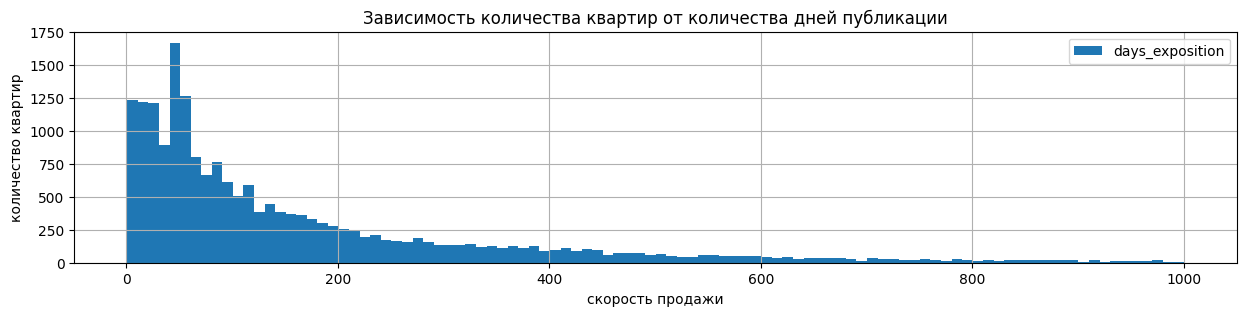

In [130]:
data.plot(y='days_exposition', kind='hist', bins=100, figsize = (15,3), grid=True, title='Зависимость количества квартир от количества дней публикации')\
.set(xlabel='скорость продажи', ylabel='количество квартир');

Посмотрим среднее, медиану и процентили для дней публикации

In [131]:
data['days_exposition'].describe(percentiles=[.25, .5, .75, .99]) 

count    19611.000000
mean       165.173729
std        185.771232
min          1.000000
25%         44.000000
50%         92.000000
75%        217.000000
99%        859.000000
max       1000.000000
Name: days_exposition, dtype: float64

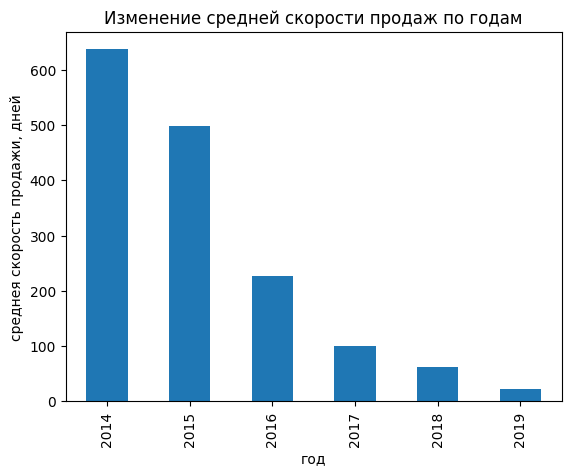

In [132]:
data.groupby('publication_year')['days_exposition'].median().plot(kind='bar', title='Изменение средней скорости продаж по годам')\
.set(xlabel='год', ylabel='среднея скорость продажи, дней');

<div style="border: solid pink 2px; padding: 20px">
    
- Будем считать быстрыми продажами те, у которых количество дней публикации меньше первого квартиля, то есть меньше 44 дней, а долгими те, у которых количество дней публикации больше третьего квартиля, то есть 217 дней. Необычно долгими можно считать те, у которых количество дней публикации больше 0,99-квартиля, то есть 859 дней.
    
- Скорость продаж увеличивается с каждым последующим годом, если в 2014 квартиру продавали в среднем за 600 дней, то в 2019 продают быстрее чем за 100 дней.

### Какие факторы больше всего влияют на общую (полную) стоимость объекта?

#### Общая площадь

In [133]:
data['last_price'].corr(data['total_area']) # коэффициент корреляции зависимости между ценой и общей площадью

0.738785407052472

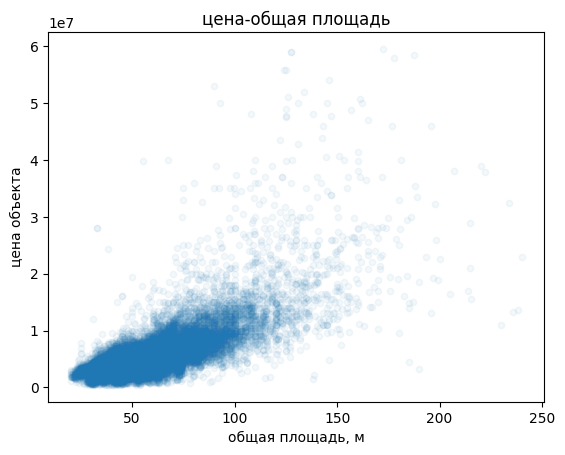

In [134]:
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.05, title='цена-общая площадь')\
.set(xlabel='общая площадь, м', ylabel='цена объекта'); # диаграмма рассеяния 

По диаграмме рассеяния видно, что это прямая зависимость цены от площади. Коэффициент корреляции достаточно большой, что показвает сильную связь между ценой и общей площадью.

#### Жилая площадь

In [135]:
data['last_price'].corr(data['living_area']) 

0.6264745378784736

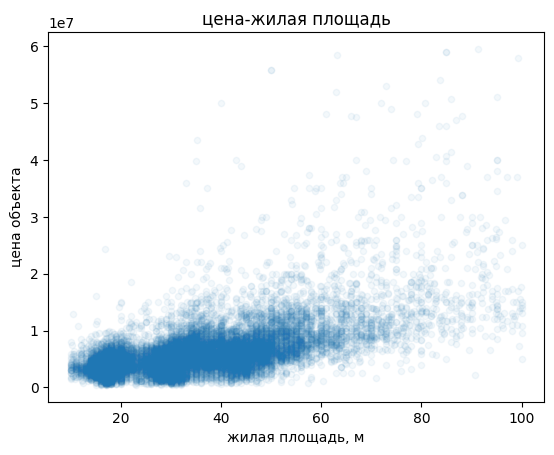

In [136]:
data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.05, title='цена-жилая площадь')\
.set(xlabel='жилая площадь, м', ylabel='цена объекта'); # диаграмма рассеяния 

Опять же, диаграмма рассеяния очень похожа на предыдущую, здесь видна прямая зависимость, но коэффициент корреляции чуть меньше, чем в зависимости "общая площадь-цена".

#### Площадь кухни

In [137]:
data['last_price'].corr(data['kitchen_area']) 

0.5306875385784736

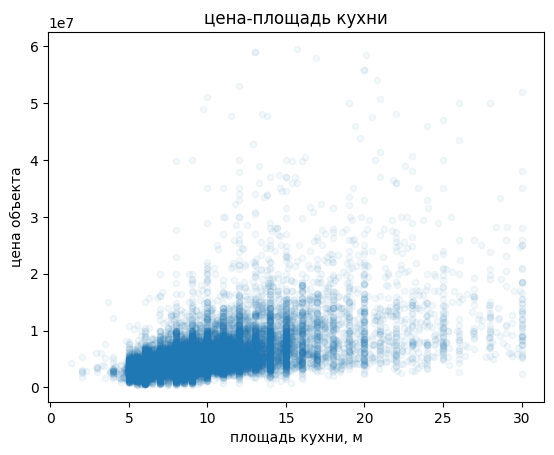

In [138]:
data.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.05, title='цена-площадь кухни')\
.set(xlabel='площадь кухни, м', ylabel='цена объекта');

Здесь же видно, что зависимость есть, но более слабая за счет того, что не смотря на большую или меньшую площадь кухни, по цене квартиры с такими кухнями могут стоить очень разных денег.

#### Количество комнат 

Столбчатая диаграмма, показывающая зависимость медианной стоимости квартиры по комнатам

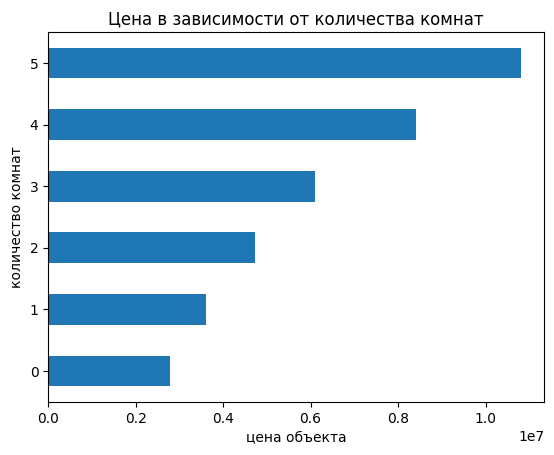

In [139]:
data.groupby('rooms')['last_price'].median().plot(kind='barh', title='Цена в зависимости от количества комнат')\
.set(xlabel='цена объекта', ylabel='количество комнат'); 

Видно, что с увеличением количества комнат происходит увеличение медианной стоимости квартиры, что согласуется с тем, что чем больше площадь квартиры, тем она стоит больше.

#### Этаж, на котором расположена квартира (первый, последний, другой)

Столбчатая диаграмма, показывающая зависимость медианной стоимости квартиры от типа этажа

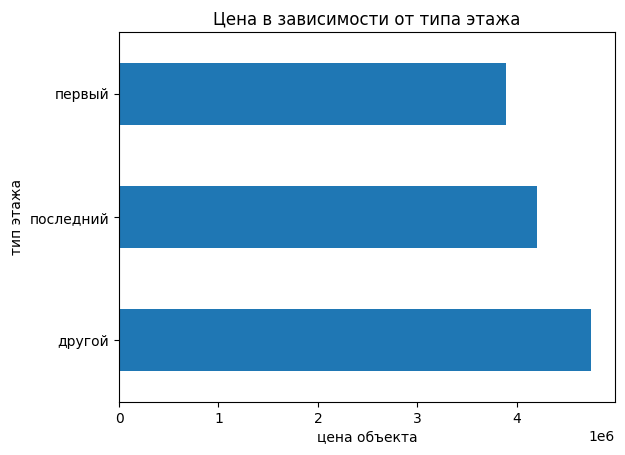

In [140]:
data.groupby('floor_type')['last_price'].median().sort_values(ascending=False)\
.plot(kind='barh', title='Цена в зависимости от типа этажа')\
.set(xlabel='цена объекта', ylabel='тип этажа'); 

По графику видно, что в целом все квартиры на "первом" этаже обошлись более дешево, чем на "последнем", но "последние", в свою очередь, обошлись дешевле, чем на "другом".

#### Дата размещения (день недели, месяц, год)

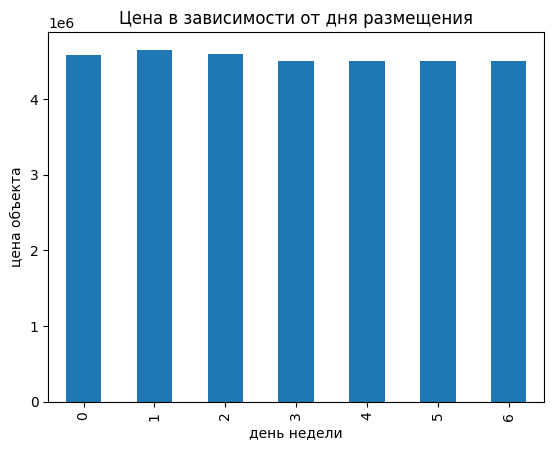

In [141]:
data.groupby('day_of_week')['last_price'].median().plot(kind='bar', title='Цена в зависимости от дня размещения')\
.set(xlabel='день недели', ylabel='цена объекта');
# столбчатая диаграмма, показывающая зависимость медианной стоимости квартиры от дня недели, в который была выложена публикация

В не зависимости от дня недели, в который было выложено объявление, цена в объявлении от этого практически не меняется.

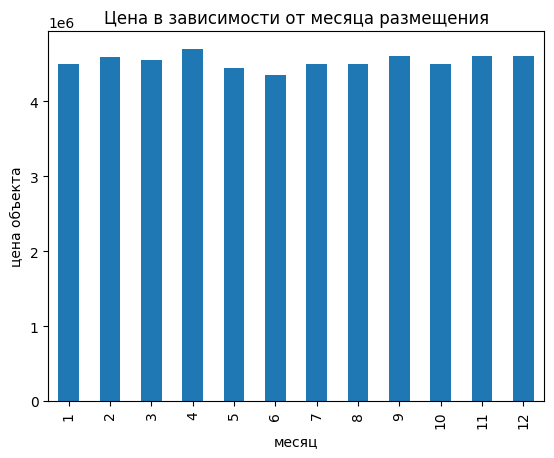

In [142]:
data.groupby('publication_month')['last_price'].median().plot(kind='bar', title='Цена в зависимости от месяца размещения')\
.set(xlabel='месяц', ylabel='цена объекта');
# столбчатая диаграмма, показывающая зависимость медианной стоимости квартиры от месяца, в который была выложена публикация

С месяцами в целом такая же ситуация, как и с днями недели, есть незначительные колебания, но в целом диаграмма ровная.

Столбчатая диаграмма, показывающая зависимость количества объявлений от года, в который они были выложены

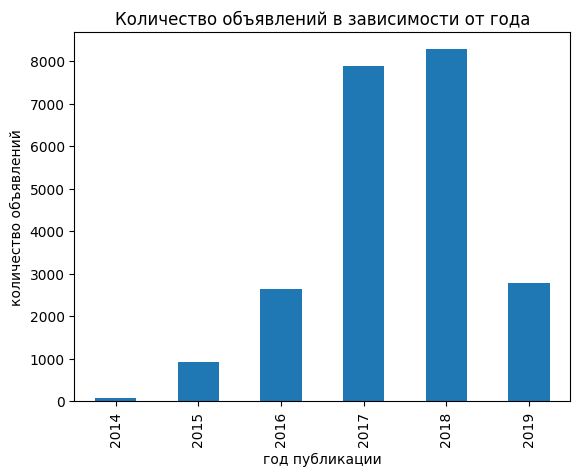

In [143]:
data.groupby('publication_year')['last_price'].count().plot(kind='bar', title='Количество объявлений в зависимости от года')\
.set(xlabel='год публикации', ylabel='количество объявлений');


Столбчатая диаграмма, показывающая зависимость медианной стоимости квартиры от года, в который была выложена публикация

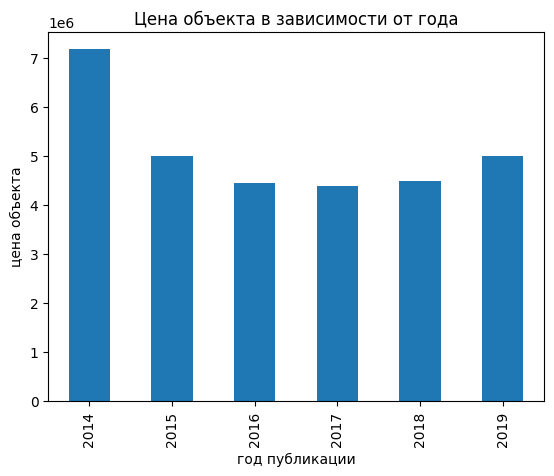

In [144]:
data.groupby('publication_year')['last_price'].median().plot(kind='bar', title='Цена объекта в зависимости от года')\
.set(xlabel='год публикации', ylabel='цена объекта');

Несмотря на то, что пик публикаций приходится на 2017-2018 года, в 2014 квартиры или стоили сильно дороже, либо их было не очень много, но достаточно дорогих.

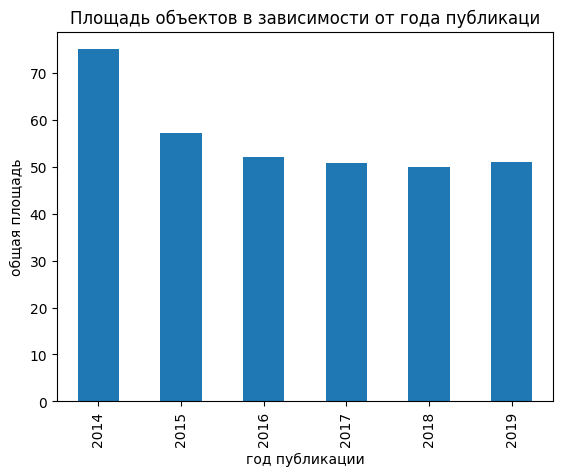

In [145]:
data.groupby('publication_year')['total_area'].median().plot(kind='bar', title='Площадь объектов в зависимости от года публикаци')\
.set(xlabel='год публикации', ylabel='общая площадь');

**Вывод:**
<div style="border: solid pink 2px; padding: 20px">

Из всех факторов, влияние общей площади на стоимость квартиры кажется самым сильным, влияние жилой площади и площади кухни тоже является закономерным. Стоимость квартир растет с ростом количества комнат, что так же косвенно связанно с увеличением общей площади. Первый этаж немного "удешивляет" квартиру. Дата и месяц размещения объявления не влияет на стоимость квартиры. Пик публикаций объявлений приходится на 2017-2018 года, самые дорогие квартиры и большие по площади квартиры продавались в 2014 году.

### Средняя цена одного квадратного метра в 10 населённых пунктах

In [146]:
name_list = data.groupby('locality_name')['price_per_m2'].count().sort_values(ascending=False).head(10).index 
# сгруппируем данные по наименованию населенного пункта, 
# посчитаем записи для каждого из них, отсортируем по возрастанию и выведем топ-10 населенных пунктов по количеству объявлений

In [147]:
data[data['locality_name'].isin(name_list)]\
.pivot_table(index='locality_name', values='price_per_m2', aggfunc='mean')\
.sort_values(by='price_per_m2', ascending=False).style.format("{:.2f}")
# выбираем записи с подходящими населенными пунктами
# из них создаем сводную таблицу со средней ценой за квадратный метр
# сортируем по убыванию

,price_per_m2
locality_name,
Санкт-Петербург,111340.69
Пушкин,102762.96
Кудрово,95311.60
Парголово,90259.74
Мурино,86120.19
Шушары,78543.28
Колпино,75279.71
Гатчина,68727.95
Всеволожск,68609.98


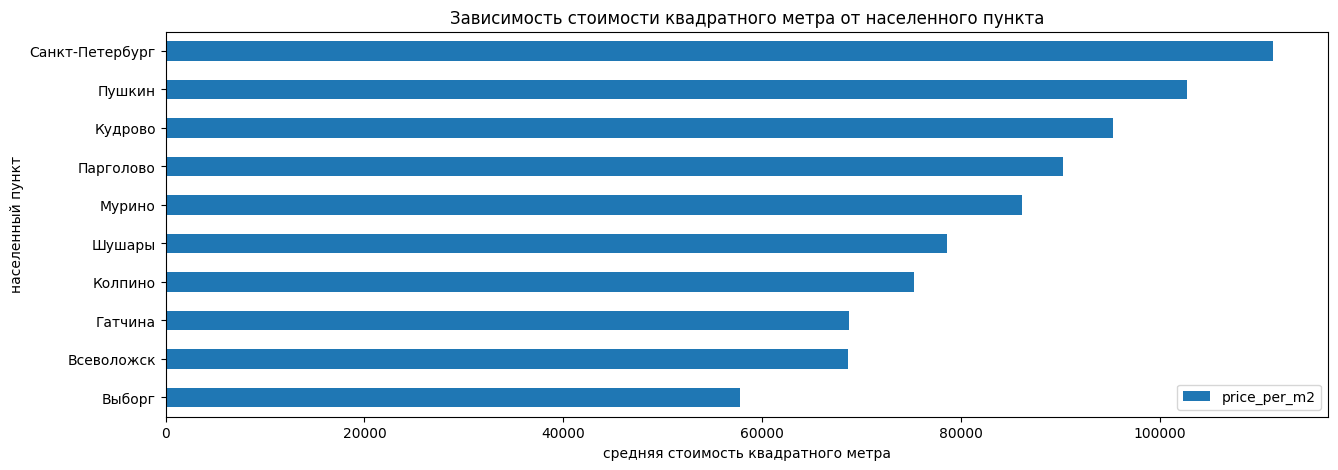

In [148]:
data[data['locality_name'].isin(name_list)]\
.pivot_table(index='locality_name', values='price_per_m2', aggfunc='mean')\
.sort_values(by='price_per_m2', ascending = True).plot(y='price_per_m2', kind='barh', figsize = (15,5), title='Зависимость стоимости квадратного метра от населенного пункта')\
.set(xlabel='средняя стоимость квадратного метра', ylabel='населенный пункт');

**Вывод:**
<div style="border: solid pink 2px; padding: 20px">
Самый дорогой квадратный метр из десяти населенных пунктов по количеству объявлений приходится на Санкт-Петербург (112775 за квадратный метр), самый недорого - на Выборг (58405 за квадратный метр).

### Опишите, как стоимость объектов зависит от расстояния до центра города.

In [149]:
data_St_Petersburg = data[data['locality_name'] == 'Санкт-Петербург'] 
# создадим таблицу, состаящую из объявлений о продаже в Санкт-Петербурге

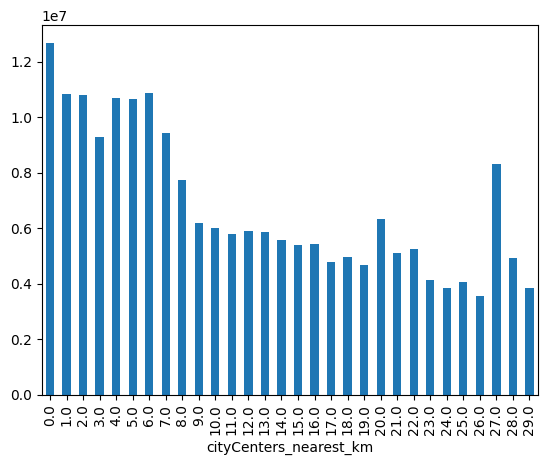

In [150]:
data_St_Petersburg.groupby('cityCenters_nearest_km')['last_price'].mean().plot(kind='bar');
# столбчатая диаграмма зависимости медианной цены от километра 

In [151]:
data_St_Petersburg[data_St_Petersburg['cityCenters_nearest_km']==3]['floor_type'].value_counts(normalize=True)

другой       0.635347
последний    0.210291
первый       0.154362
Name: floor_type, dtype: float64

In [152]:
data_St_Petersburg[data_St_Petersburg['cityCenters_nearest_km']==4]['floor_type'].value_counts(normalize=True)

другой       0.751316
последний    0.146053
первый       0.102632
Name: floor_type, dtype: float64

In [153]:
# check
data_St_Petersburg[data_St_Petersburg['cityCenters_nearest_km']==5]['floor_type'].value_counts(normalize=True)

другой       0.748068
последний    0.143740
первый       0.108192
Name: floor_type, dtype: float64

Доля квартир на "другом" этаже выросла с переходом от третьего к четвертому километру от центра, а доля "последнего" и "первого" упала. Исходя из 4.3.5, где мы выяснили что квартиры на "другом" этаже дороже всего, а квартиры на "первом" дешевле, из-за роста доли квартир на "другом" этаже, средняя цена квартиры при переходе с третьего на четвертый километр выросла.

In [154]:
data_St_Petersburg[data_St_Petersburg['cityCenters_nearest_km']==8]['floor_type'].value_counts(normalize=True)

другой       0.781553
последний    0.126214
первый       0.092233
Name: floor_type, dtype: float64

In [155]:
data_St_Petersburg[data_St_Petersburg['cityCenters_nearest_km']==9]['floor_type'].value_counts(normalize=True)

другой       0.756024
последний    0.153614
первый       0.090361
Name: floor_type, dtype: float64

При переходе с восьмого на девятый километр доля "последнего" и "первого" этажей выросла, а "другого" упала, что уменьшило среднюю стоимость квартиры

In [156]:
data_St_Petersburg[data_St_Petersburg['cityCenters_nearest_km']==19]['floor_type'].value_counts(normalize=True)

другой       0.790123
последний    0.148148
первый       0.061728
Name: floor_type, dtype: float64

In [157]:
data_St_Petersburg[data_St_Petersburg['cityCenters_nearest_km']==20]['floor_type'].value_counts(normalize=True)

другой       0.827160
последний    0.098765
первый       0.074074
Name: floor_type, dtype: float64

При переходе с девятнадцатого на двадцатый километр доля "последнего" и "первого" упала, а"другого" выросла, что повлекло увеличение средней стоимости квартиры.

In [158]:
data_St_Petersburg[data_St_Petersburg['cityCenters_nearest_km']==27] # проверим пик около 27 км

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,day_of_week,publication_month,publication_year,floor_type,cityCenters_nearest_km
748,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,False,...,1496.0,0.0,NaN,128.0,193918.918919,1,11,2017,другой,27.0
5961,6,2250000.0,32.0,2018-02-27,1,2.65,2,16.5,2,False,...,NaN,0.0,NaN,178.0,70312.500000,1,2,2018,последний,27.0


По диаграмме видно, что самое дорогое жилье - очевидно - находится ближе всего к центру. Пики около 3-4, 8-9 и 19-20 километров объяснены изменением доли квартир с разными типами этажей. Пик около 27 км объясняется дорогой квартирой за 14 милионнов, это скорее исключение, чем правило.

In [159]:
data_price_per_km = data_St_Petersburg.groupby('cityCenters_nearest_km')['price_per_m2'].median().\
to_frame(name='price_per_m2_median')
# создадим таблицу из медианной цены квадратного метра для каждого километра

In [160]:
data_price_per_km['diff'] = data_price_per_km['price_per_m2_median'].diff()
# добавим столбец diff с разностью между медианными ценами 

In [161]:
data_price_per_km.head()

,price_per_m2_median,diff
cityCenters_nearest_km,,
0.0,125565.610860,NaN
1.0,122448.979592,-3116.631268
2.0,116158.293042,-6290.686550
3.0,108892.921960,-7265.371082
4.0,125374.416026,16481.494066


In [162]:
data_price_per_km['diff'].mean() # среднее значение разности между ценами за квадратный метр 

-2365.1333335752415

**Вывод:**
<div style="border: solid pink 2px; padding: 20px">
В среднем с каждым километром от центра квадратный метр квартиры дешевеет на 2400.

## Общий вывод

**Вывод:**
<div style="border: solid pink 2px; padding: 20px">

1. В таблице много пропусков, на это стоит обратить внимание. Возможно стоит при заполнении объявления некоторые поля обязательными для ввода, например жилую площадь, населенный пункт, высота потолков, этажность дома (возможно).

2. Причину выбросов, связанных с 45 и 60 днями публикаций, определить не удалось, возможно стоит получить какие-то дополнительные данные. При исключении этих записей выяснилось, что чаще всего квартиры продают на 7, 30 и 90 дни.

3. Большинство квартир имеет стандартные площади, соответствующие трем видам стандартных квартир (1, 2, и 3-х комнатные). Кухни чаще всего бывают около 7-12 метров. Гистрограмма цен имеет плавный вид, немного растянута к большим значениям цены. В основном все квартиры имеют потолки около 2-4 метров. Большинство квартир находятся от первого до пятого этажа и, в основном, квартиры находятся не на первом или последних этажах. Больше всего домов - пятиэтажные, также много девятиэтажных домов. Большинство проданных квартир находятся на расстоянии около 15000 м от центра города, на расстоянии от 20000 м до 40000 м от аэропорта, и, если в пределах 3-х километров есть парк, то он находится не дальше 1000 метров. Чаще объявления выкладывают в будние дни весной и осенью.

4. Срок быстрых продаж - меньше 44 дней, а долгих - больше 217 дней. Необычно долгих - больше 859 дней. Скорость продаж увеличивается с каждым последующим годом, если в 2014 квартиру продавали в среднем за 600 дней, то в 2019 продают быстрее чем за 100 дней.
    
5. Из всех факторов, влияние общей площади на стоимость квартиры кажется самым сильным. Дата и месяц размещения объявления не влияет на стоимость квартиры. Пик публикаций объявлений приходится на 2017-2018 года, самые дорогие квартиры и большие по площади квартиры продавались в 2014 году.
  
6. Самый дорогой квадратный метр из десяти населенных пунктов по количеству объявлений приходится на Санкт-Петербург (112775 за квадратный метр), самый недорого - на Выборг (58405 за квадратный метр). В среднем с каждым километром от центра квадратный метр квартиры дешевеет на 2400. По диаграмме видно, что самое дорогое жилье - очевидно - находится ближе всего к центру. Пики около 3-4, 8-9 и 19-20 километров объяснены изменением доли квартир с разными типами этажей. 